In [29]:
import io
!pip install librosa
!pip install jiwer
!pip install pytorch

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Running setup.py bdist_wheel for pytorch ... error
  Complete output from command /usr/local/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-build-r0mhif2a/pytorch/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/tmpb5iffa45pip-wheel- --python-tag cp36:
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "/tmp/pip-build-r0mhif2a/pytorch/setup.py", line 17, in <module>
      raise Exception(message)
  Exception: You should install pytorch from http://pytorch.org
  
  ----------------------------------------
  Failed building wheel for pytorch
  

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy
import os
import torch
#from torch.nn import CTCLoss
from warpctc_pytorch import CTCLoss
from ctcdecode import CTCBeamDecoder
import itertools
#import jiwer
import random

In [3]:
#Functions for file manipulation
def load_samples(file_path):
    ys, srs = [[]],[[]]
    i = 0
    #loads .wav files
    for filename in os.listdir(file_path):
        if filename.endswith(".wav"):
            y, sr = librosa.load(file_path+filename, sr=16000)
            ys[i].append(y)
            srs[i].append(sr)
            i = i + 1
            ys.append([])
            srs.append([])  
    ys = ys[0: len(ys) - 1]
    srs = srs[0: len(srs) - 1]
    return (ys, srs)


def load_labels(file_path):
    i = 0
    labels = [[]]
    
    for filename in os.listdir(file_path):
        if filename.endswith(".txt"):
            file = open(file_path+filename, "r") 
            labels[i].append(file.read())
            labels.append([])
            i = i + 1
            
    labels=labels[0: len(labels) - 1]
    return labels

In [4]:
#Functions for feature extraction
def find_max(ys):
    """
    Searches for the longest same.
    used for padding.
    ys - [num_samples] x [sample_length]
    
    returns
    max(sample_length)
    """
    
    maximum =0
    for y1 in ys:
        for y2 in y1:
            dim = y2.shape[0]
            if dim > maximum:
                maximum = dim
    return maximum

def pad_signal(ys, max_length):
    """
    pads the signal
    
    Signals are not of the same length, so samples that are shorter then longest signal are padded
    ys - [num_samples] x [sample_length]
    
    returns
    [num_samples] x [sample_length] - sample_length is now same for each sample
    """
    
    
    ys_new = ys
    for i, y1 in enumerate(ys_new):
        for j, y2 in enumerate(y1):
            if len(y2) < max_length:
                z = numpy.zeros((max_length - len(y2)))
                pad_signal = numpy.append(y2, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
                ys_new[i][j] = pad_signal
    return ys_new
def pre_emphasize(ys, pre_emphasis = 0.97):
    """
    Performs pre emphasis
    
    ys - ys - input array of all samples [num_samples] x [sample_length]
    pre_emphasis - pre emphasis factor, usually 0.97
    
    returns
    [num_samples] x [sample_length] - emphasized signal
    """
    for i, y in enumerate(ys):
        signal=y[0]
        y[0] = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    return ys
def fourier_transform(ys, N_FFT=512, window='hamming', hop_size=256):
    """
    Performs stft
    
    ys - input array of all samples [num_samples] x [sample_length]
    N_FFT - number of FFTs
    window - window function - e.g. hanning, or hamming etc.
    hop_size - self explanatory
    
    returns Ds [num_samples] x [1] x [sequence_length] x [N_FFT/2 + 1] - returns spectrogram of the sample. It is a bit stupid, since there is one extra
    unncessary dimension, it`s mostly because working with numpy arrays is ... 
    
    """
    
    Ds = [[]]

    for i, y in enumerate(ys):
        Ds[i].append(librosa.core.stft(y=y[0], n_fft=N_FFT, window=window, hop_length=hop_size))
        Ds.append([])
    return Ds

def mfccs(ys, N_FFT=512, sr=16000, n_mfcc=40, hop_size=256):
    """
    Extracts mel features
    
    ys - input array of all samples [num_samples] x [sample_length]
    N_FFT - number of FFTs
    sr - sampling rate
    n_mfcc - number of mfcc features
    hop_size - self explanatory
    
    returns
    mels [num_samples] x [1] x [sequence_length] x [n_mfcc] - returns mel features. It is a bit stupid, since there is one extra
    unncessary dimension, it`s mostly because working with numpy arrays is ...
    """
    mels = [[]]
    
    for i, y in enumerate(ys):
        mels[i].append(librosa.feature.mfcc(y[0], sr=sr, n_mfcc=n_mfcc, n_fft=N_FFT, hop_length=hop_size))
        mels.append([])
    return mels

In [31]:
def display_cost(costs, num_epochs):
    print(len(costs))
    x = numpy.arange(0, num_epochs, 1)
    print(len(x))
    print(num_epochs)
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.plot(x, costs)
    plt.show()
    

def greedy_decoder(outs, all_labels):
    """
    """
    
    outputs=outs
    string=[]
    maximals, indices = outputs.max(1)
    for i in indices:
        string.append(all_labels[i])
    itertools.groupby(string)
    string=[k for k, g in itertools.groupby(string)]
    output =[]
    for s in string:
        if s != "-":
            output.append(s)
    
    print(output)
    return output

def WER(predicted, ground_truth):
    arr=numpy.zeros([len(predicted) + 1, len(ground_truth) + 1])
    
    
    i = 0
    while i < len(arr):
        j = 0
        
        while j < len(arr[i]):
            if i == 0:
                arr[0][j] = j
            elif j == 0:
                arr[i][0] = i
    
            j = j + 1
        i = i + 1
        
    i = 1
    while i < len(arr):
        
        j = 1
        while j < len(arr[i]):
            if predicted[i - 1] == ground_truth[j - 1]:
                arr[i][j] = arr[i - 1][j - 1]
            else:
                replace = arr[i-1][j-1] + 1
                insert  = arr[i][j-1]   + 1
                delete  = arr[i-1][j]   + 1
                arr[i][j]=min(replace, insert, delete)
            j = j + 1
        i = i + 1
    
    return arr[len(predicted)][len(ground_truth)]/len(predicted.split())
    

# Step 1
* we open the samples and labels

In [6]:
path = "an4_dataset/train/"#path to the dataset

ys, srs = load_samples(path)
labels = load_labels(path)

In [7]:
path2 = "an4_dataset/validation/"

ys_valid, srs = load_samples(path2)
labels_valid = load_labels(path2)

# Step 2
* loaded data is preprocessed
* we perform stft using librosa
* then we add melspectrogram
* and MFCCs, all are prepared, but we can use each of them, so we get different kinds of features

**Note**: For stft we have a window size, typically 512 or 256 and hop size. On each iteration we start at 
$$
n_1 = N_f x H
$$
and we finish at
$$
n_2 = n_1 + M - 1
$$

https://dsp.stackexchange.com/questions/38491/time-position-in-stft-output

H is a hop size (length) and M is a window size.

In [8]:
train_max=find_max(ys=ys)
valid_max=find_max(ys=ys_valid)
max_len= train_max if train_max>valid_max else valid_max

ys_new = pad_signal(ys, max_len)
ys_valid_new=pad_signal(ys_valid, max_len)

ys_emphasized=pre_emphasize(ys_new, 0.97)
ys_valid_emphasize=pre_emphasize(ys_valid_new, 0.97)

In [9]:
N_FFT = 400 #window size
window = 'hamming'
hop_size = 160
N_MFCC = 40

#Ds=fourier_transform(ys=ys_emphasized, N_FFT=N_FFT, window=window, hop_size=hop_size)
Ms=mfccs(ys=ys_emphasized, n_mfcc=N_MFCC, N_FFT=N_FFT, hop_size=hop_size)
Ms_valid=mfccs(ys=ys_valid_emphasize, n_mfcc=N_MFCC, N_FFT=N_FFT, hop_size=hop_size)

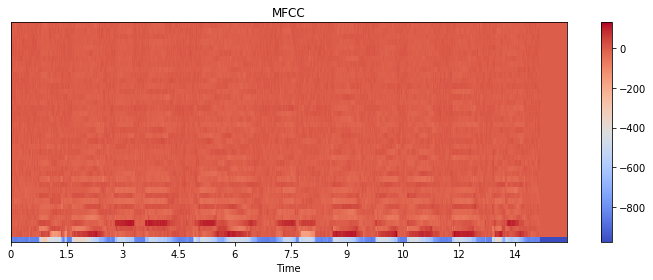

In [10]:
#Here we plot mel spectrogram of one of the samples. Since this sample is pretty 
#long, we have something over the whole time period
plt.figure(figsize=(10, 4))
librosa.display.specshow(Ms[1][0], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()


# Step 3

Here we create a neural network, define loss function (CTCLoss in our case) and optimizer.

In [11]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool1d, Dropout2d, Conv1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [49]:
# hyperameters of the model
num_classes = 28
channels = 1
height = 641
width = 40

num_filters_conv1 = 32
kernel_size_conv1 = (2,5) # [height, width]
stride_conv1 = (2, 2) # [stride_height, stride_width]
padding_conv1 = (0,3)
dilation_conv1 = (1, 1)


stride_pool1 = 2
kernel_size_pool1 = 2
padding_pool1 = 0
dilation_pool1 = 1

#convolutional layer
num_filters_conv2 = 96
kernel_size_conv2 = (2, 5) # [height, width]
stride_conv2 = (1, 1) # [stride_height, stride_width]
padding_conv2 = (0,0)
dilation_conv2 = (1,1)

stride_pool2 = 2
kernel_size_pool2 = 2
padding_pool2 = 0
dilation_pool2 = 1

#3rd convolutional layer
num_filters_conv3 = 96
kernel_size_conv3 = (1,5) # [height, width]
stride_conv3 = (1,1) # [stride_height, stride_width]
padding_conv3 = (0,0)
dilation_conv3 = (1,1)


stride_pool3 = 2
kernel_size_pool3 = 2
padding_pool3 = 0
dilation_pool3 = 1

#4th convolutional layer
num_filters_conv4 = 96
kernel_size_conv4 = (1,5) # [height, width]
stride_conv4 = (1, 1) # [stride_height, stride_width]
padding_conv4 = (0,0)
dilation_conv4 = (1,1)

#5th convolutional layer
num_filters_conv5 = 64
kernel_size_conv5 = (1,5) # [height, width]
stride_conv5 = (1, 1) # [stride_height, stride_width]
padding_conv5 = (0,0)
dilation_conv5 = (1,1)

#6th convolutional layer
num_filters_conv6 = 64
kernel_size_conv6 = (1,3) # [height, width]
stride_conv6 = (1, 1) # [stride_height, stride_width]
padding_conv6 = (0,0)
dilation_conv6 = (1,1)

#7th convolutional layer
num_filters_conv7 = 64
kernel_size_conv7 = (1,3) # [height, width]
stride_conv7 = (1, 1) # [stride_height, stride_width]
padding_conv7 = (0,0)
dilation_conv7 = (1,1)



#8th convolutional layer
num_filters_conv8 = 32
kernel_size_conv8 = (1,1) # [height, width]
stride_conv8 = (1, 1) # [stride_height, stride_width]
padding_conv8 = (0,0)
dilation_conv8 = (1,1)

#9th convolutional layer
num_filters_conv9 = 32
kernel_size_conv9 = (1,1) # [height, width]
stride_conv9 = (1, 1) # [stride_height, stride_width]
padding_conv9 = (0,0)
dilation_conv9 = (1,1)


#10th convolutional layer
num_filters_conv10 = 32
kernel_size_conv10 = (1,1) # [height, width]
stride_conv10 = (1, 1) # [stride_height, stride_width]
padding_conv10 = (0,0)
dilation_conv10 = (1,1)

batch_size=48
num_l1 = 512
dilation=1

def compute_conv_dim(dim_size):
    return int((dim_size - kernel_size_conv1 + 2 * padding_conv1) / stride_conv1 + 1)

def compute_maxPool_dim(dim_size):
    return int((dim_size - kernel_size_pool1 + 2 * padding_conv1) / stride_pool1 + 1)


def compute_conv_dim_1d(L_in, kernel_in, padding_in = 0, dilation_in = 1, stride_in = 1):
    return int((L_in + 2*padding_in - dilation_in*(kernel_in - 1) - 1)/stride_in + 1)

def compute_conv_height_2d(H_in, kernel_size_height, padding_height=0, dilation_height=1, stride_height=1):
    return int((H_in+2*padding_height-dilation_height*(kernel_size_height - 1) - 1)/stride_height + 1)

def compute_conv_width_2d(W_in,  kernel_size_width, padding_width=0, dilation_width=1, stride_width=1):
    return int((W_in+2*padding_width-dilation_width*(kernel_size_width-1) - 1)/stride_width + 1)

def compute_pool_dim_1d(L_in, kernel_in, padding_in = 0, dilation_in = 1, stride_in = 1):
    return int((L_in + 2*padding_in - dilation_in*(kernel_in - 1) - 1)/stride_in + 1)
    
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #out_dim = (input_dim - filter_dim + 2 * padding) / stride + 1
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1,
                             padding=padding_conv1,
                             dilation=dilation_conv1)
        
        self.conv_width_1=compute_conv_width_2d(W_in=width, kernel_size_width=kernel_size_conv1[1],
                                                padding_width=padding_conv1[1], dilation_width=dilation_conv1[1],
                                                stride_width=stride_conv1[1])
        self.conv_height_1=compute_conv_height_2d(H_in=height, kernel_size_height=kernel_size_conv1[0],
                                                  padding_height=padding_conv1[0], dilation_height=dilation_conv1[0],
                                                  stride_height=stride_conv1[0])
        
        print(self.conv_width_1)
        print(self.conv_height_1)
        
        self.conv_dropout_1=torch.nn.Dropout2d(p=0.4)
        #self.conv_batchnorm_1=torch.nn.BatchNorm2d(num_filters_conv1)
        
        self.conv_2 = Conv2d(in_channels=num_filters_conv1,
                             out_channels=num_filters_conv2,
                             kernel_size=kernel_size_conv2,
                             stride=stride_conv2,
                             padding=padding_conv2,
                             dilation=dilation_conv2)
        
        
        
        
        self.conv_width_2=compute_conv_width_2d(W_in=self.conv_width_1, kernel_size_width=kernel_size_conv2[1],
                                                padding_width=padding_conv2[1], dilation_width=dilation_conv2[1],
                                                stride_width=stride_conv2[1])
        self.conv_height_2=compute_conv_height_2d(H_in=self.conv_height_1, kernel_size_height=kernel_size_conv2[0],
                                                  padding_height=padding_conv2[0], dilation_height=dilation_conv2[0],
                                                  stride_height=stride_conv2[0])
        
        print(self.conv_width_2)
        print(self.conv_height_2)
        
        
        self.conv_dropout_2=torch.nn.Dropout2d(p=0.2)
        self.conv_batchnorm_2=torch.nn.BatchNorm2d(num_filters_conv2)
        
        self.conv_3 = Conv2d(in_channels=num_filters_conv2,
                             out_channels=num_filters_conv3,
                             kernel_size=kernel_size_conv3,
                             stride=stride_conv3,
                             padding=padding_conv3,
                             dilation=dilation_conv3)
        
        
        self.conv_width_3=compute_conv_width_2d(W_in=self.conv_width_2, kernel_size_width=kernel_size_conv3[1],
                                                padding_width=padding_conv3[1], dilation_width=dilation_conv3[1],
                                                stride_width=stride_conv3[1])
        self.conv_height_3=compute_conv_height_2d(H_in=self.conv_height_2, kernel_size_height=kernel_size_conv3[0],
                                                  padding_height=padding_conv3[0], dilation_height=dilation_conv3[0],
                                                  stride_height=stride_conv3[0])
        print(self.conv_width_3)
        print(self.conv_height_3)
        
        
        self.conv_dropout_3=torch.nn.Dropout2d(p=0.1)
        #self.conv_batchnorm_3=torch.nn.BatchNorm2d(num_filters_conv3)
        
        self.conv_4 = Conv2d(in_channels=num_filters_conv3,
                             out_channels=num_filters_conv4,
                             kernel_size=kernel_size_conv4,
                             stride=stride_conv4,
                             padding=padding_conv4,
                             dilation=dilation_conv4)
        
        
        
        self.conv_width_4=compute_conv_width_2d(W_in=self.conv_width_3, kernel_size_width=kernel_size_conv4[1],
                                                padding_width=padding_conv4[1], dilation_width=dilation_conv4[1],
                                                stride_width=stride_conv4[1])
        self.conv_height_4=compute_conv_height_2d(H_in=self.conv_height_3, kernel_size_height=kernel_size_conv4[0],
                                                  padding_height=padding_conv4[0], dilation_height=dilation_conv4[0],
                                                  stride_height=stride_conv4[0])
        
        
        
        self.conv_dropout_4=torch.nn.Dropout2d(p=0.05)
        self.conv_batchnorm_4=torch.nn.BatchNorm2d(num_filters_conv4)
        
        
        self.conv_5 = Conv2d(in_channels=num_filters_conv4,
                             out_channels=num_filters_conv5,
                             kernel_size=kernel_size_conv5,
                             stride=stride_conv5,
                             padding=padding_conv5,
                             dilation=dilation_conv5)
        
        
        
        self.conv_width_5=compute_conv_width_2d(W_in=self.conv_width_4, kernel_size_width=kernel_size_conv5[1],
                                                padding_width=padding_conv5[1], dilation_width=dilation_conv5[1],
                                                stride_width=stride_conv5[1])
        self.conv_height_5=compute_conv_height_2d(H_in=self.conv_height_4, kernel_size_height=kernel_size_conv5[0],
                                                  padding_height=padding_conv5[0], dilation_height=dilation_conv5[0],
                                                  stride_height=stride_conv5[0])
        
        
        #self.conv_dropout_4=torch.nn.Dropout2d(p=0.05)
        #self.conv_batchnorm_4=torch.nn.BatchNorm2d(num_filters_conv4)
        
        self.conv_6 = Conv2d(in_channels=num_filters_conv5,
                             out_channels=num_filters_conv6,
                             kernel_size=kernel_size_conv6,
                             stride=stride_conv6,
                             padding=padding_conv6,
                             dilation=dilation_conv6)
        
        
        
        self.conv_width_6=compute_conv_width_2d(W_in=self.conv_width_5, kernel_size_width=kernel_size_conv6[1],
                                                padding_width=padding_conv6[1], dilation_width=dilation_conv6[1],
                                                stride_width=stride_conv6[1])
        self.conv_height_6=compute_conv_height_2d(H_in=self.conv_height_5, kernel_size_height=kernel_size_conv6[0],
                                                  padding_height=padding_conv6[0], dilation_height=dilation_conv6[0],
                                                  stride_height=stride_conv6[0])
        
        self.conv_7 = Conv2d(in_channels=num_filters_conv6,
                             out_channels=num_filters_conv7,
                             kernel_size=kernel_size_conv7,
                             stride=stride_conv7,
                             padding=padding_conv7,
                             dilation=dilation_conv7)
        
        
        
        self.conv_width_7=compute_conv_width_2d(W_in=self.conv_width_6, kernel_size_width=kernel_size_conv7[1],
                                                padding_width=padding_conv7[1], dilation_width=dilation_conv7[1],
                                                stride_width=stride_conv7[1])
        self.conv_height_7=compute_conv_height_2d(H_in=self.conv_height_6, kernel_size_height=kernel_size_conv7[0],
                                                  padding_height=padding_conv7[0], dilation_height=dilation_conv7[0],
                                                  stride_height=stride_conv7[0])
        
        self.conv_8 = Conv2d(in_channels=num_filters_conv7,
                             out_channels=num_filters_conv8,
                             kernel_size=kernel_size_conv8,
                             stride=stride_conv8,
                             padding=padding_conv8,
                             dilation=dilation_conv8)
        
        
        
        self.conv_width_8=compute_conv_width_2d(W_in=self.conv_width_7, kernel_size_width=kernel_size_conv8[1],
                                                padding_width=padding_conv8[1], dilation_width=dilation_conv8[1],
                                                stride_width=stride_conv8[1])
        self.conv_height_8=compute_conv_height_2d(H_in=self.conv_height_7, kernel_size_height=kernel_size_conv8[0],
                                                  padding_height=padding_conv8[0], dilation_height=dilation_conv8[0],
                                                  stride_height=stride_conv8[0])
        
        
        self.conv_9 = Conv2d(in_channels=num_filters_conv8,
                             out_channels=num_filters_conv9,
                             kernel_size=kernel_size_conv9,
                             stride=stride_conv9,
                             padding=padding_conv9,
                             dilation=dilation_conv9)
        
        
        
        self.conv_width_9=compute_conv_width_2d(W_in=self.conv_width_8, kernel_size_width=kernel_size_conv9[1],
                                                 padding_width=padding_conv9[1], dilation_width=dilation_conv9[1],
                                                 stride_width=stride_conv9[1])
        self.conv_height_9=compute_conv_height_2d(H_in=self.conv_height_8, kernel_size_height=kernel_size_conv9[0],
                                                  padding_height=padding_conv9[0], dilation_height=dilation_conv9[0],
                                                  stride_height=stride_conv9[0])
        
        self.conv_10 = Conv2d(in_channels=num_filters_conv9,
                             out_channels=num_filters_conv10,
                             kernel_size=kernel_size_conv10,
                             stride=stride_conv10,
                             padding=padding_conv10,
                             dilation=dilation_conv10)
        
        
        
        self.conv_width_10=compute_conv_width_2d(W_in=self.conv_width_9, kernel_size_width=kernel_size_conv10[1],
                                                 padding_width=padding_conv10[1], dilation_width=dilation_conv10[1],
                                                 stride_width=stride_conv10[1])
        self.conv_height_10=compute_conv_height_2d(H_in=self.conv_height_9, kernel_size_height=kernel_size_conv10[0],
                                                  padding_height=padding_conv10[0], dilation_height=dilation_conv10[0],
                                                  stride_height=stride_conv10[0])
        
        
        
        self.l1_in_features = self.conv_width_8*num_filters_conv8
        #self.l1_in_features = channels * height * width
        
        self.l_1 = Linear(in_features=self.l1_in_features, 
                          out_features=num_l1,
                          bias=True)
        self.l_out = Linear(in_features=num_l1, 
                            out_features=num_classes,
                            bias=False)
    
    def forward(self, x): # x.size() = [batch, channel, height, width]
        #print(x.shape)
        #(641, 1, 40)
        x = relu(self.conv_1(x))
        #x = self.conv_dropout_1(x)
        #x = self.conv_batchnorm_1(x)
        #torch.Size([641, 16, 38])
        #x = self.maxPool_1(x)
        #([641, 16, 19])
        x = relu(self.conv_2(x))
        #x = self.conv_dropout_2(x)
        #x = self.conv_batchnorm_2(x)
        #print(x.shape)
        #x = self.maxPool_2(x)
        
        x = relu(self.conv_3(x))
        x = self.conv_dropout_3(x)
        #x = self.conv_batchnorm_3(x)
        
        x = relu(self.conv_4(x))
        x = self.conv_dropout_4(x)
        #x = self.conv_batchnorm_4(x)
        
        x=relu(self.conv_5(x))
        x=relu(self.conv_6(x))
        x=relu(self.conv_7(x))
        x=relu(self.conv_8(x))
        #x=relu(self.conv_9(x))
        #x=relu(self.conv_10(x))
        
        #x = self.maxPool_3(x)
        #print(x.shape)
        #x = x.view(1,  641, self.l1_in_features)
        x.permute(0,2,1,3)
        x = x.view(batch_size, self.conv_height_8, self.l1_in_features)
        x = relu(self.l_1(x))
        
        # torch.Tensor.view: http://pytorch.org/docs/master/tensors.html?highlight=view#torch.Tensor.view
        #   Returns a new tensor with the same data as the self tensor,
        #   but of a different size.
        # the size -1 is inferred from other dimensions 
        #print(x.shape)#NCHW to HCNW
        #x=x.permute(0, 2, 1, 3)
        #print(x.shape)
        #x=x.contiguous()
        
        #print(x.shape)
        #x = self.dropout(relu(self.l_1(x)))
        #x = relu(self.l_1(x))
        #print(x.shape)
        return torch.nn.functional.log_softmax(self.l_out(x), dim=1)
        #return self.l_out(x)


net = Net()
print(net)

21
320
17
319
13
319
Net(
  (conv_1): Conv2d(1, 32, kernel_size=(2, 5), stride=(2, 2), padding=(0, 3))
  (conv_dropout_1): Dropout2d(p=0.4)
  (conv_2): Conv2d(32, 96, kernel_size=(2, 5), stride=(1, 1))
  (conv_dropout_2): Dropout2d(p=0.2)
  (conv_batchnorm_2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(96, 96, kernel_size=(1, 5), stride=(1, 1))
  (conv_dropout_3): Dropout2d(p=0.1)
  (conv_4): Conv2d(96, 96, kernel_size=(1, 5), stride=(1, 1))
  (conv_dropout_4): Dropout2d(p=0.05)
  (conv_batchnorm_4): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_5): Conv2d(96, 64, kernel_size=(1, 5), stride=(1, 1))
  (conv_6): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
  (conv_7): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1))
  (conv_8): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv_9): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv_10): Conv2d(32, 32, kernel_size=(1, 1), 

In [50]:
criterion = CTCLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Step 4

* In here we prepare the lables - characters A - Z, space and blank character
* number of samples used for training
* number of epochs for the training

In [51]:
num_epochs = 1000
valid_epochs=10
num_samples = 948
all_labels= [
    "-",
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "J",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    " ",
]
print(all_labels)

['-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ' ']


# Step 5

* In here we train the network

With batch

Number of epochs: 2
2
2
2


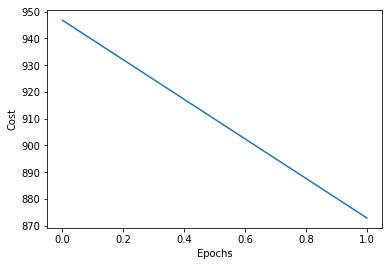

Number of epochs: 4
4
4
4


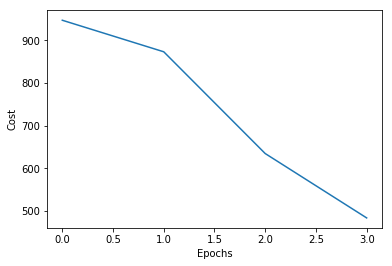

Number of epochs: 6
6
6
6


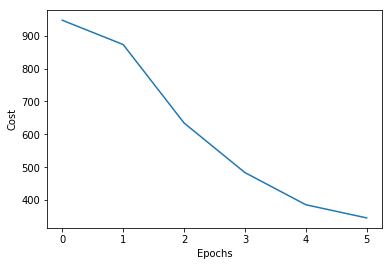

Number of epochs: 8
8
8
8


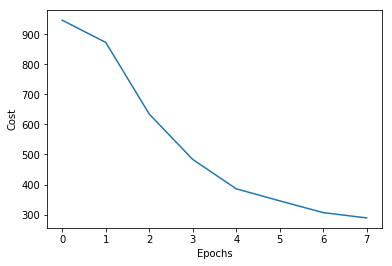

Number of epochs: 10
10
10
10


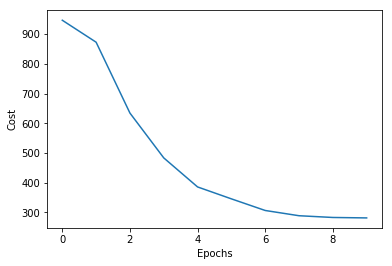

[82, 67, 21, 125, 110, 42, 10, 12, 120, 126, 87, 112, 86, 92, 105, 3, 45, 67, 75, 127, 12, 92, 106, 92, 94, 99, 15, 55, 91, 76, 69, 112, 71, 83, 22, 100, 124, 91, 82, 47, 127, 59, 70, 49, 125, 16, 27, 34]
['I', ' ', 'I', 'I', ' ', 'Q', 'B', ' ', 'I', 'I', 'I', ' ', 'I', 'I']
Predicted: I II QB III II
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
6.2
['I', 'I', ' ', 'I', 'K', 'B', 'L', ' ', 'I', 'I', 'I', ' ', 'I', ' ', 'I']
Predicted: II IKBL III I I
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
6.6
['I', 'I', ' ', 'I', 'M', 'J', 'T', 'Z', 'R', ' ', 'I', 'I', 'I', 'I', 'I', ' ']
Predicted: II IMJTZR IIIII 
Ground truth: P L E A S A N T H I L L S
WER: 
6.666666666666667
['I', ' ', 'I', 'I', ' ', 'F', 'N', 'J', 'B', 'N', ' ', 'I', 'I', 'I', 'I', ' ', ' ', 'I']
Predicted: I II FNJBN IIII  I
Ground truth: E R I C
WER: 
2.8
['I', 'I', 'I', 'F', 'L', 'J', 'V', 'A', 'N', ' ', 'I', 'I', 'I', 'I', 'I']
Predicted: IIIFLJVAN IIIII
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.

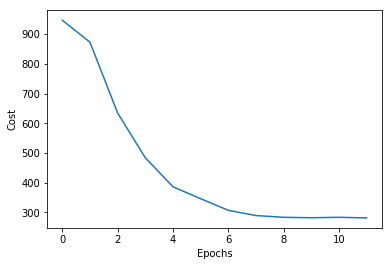

Number of epochs: 14
14
14
14


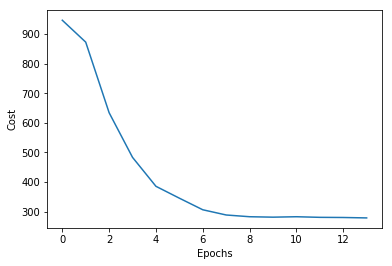

Number of epochs: 16
16
16
16


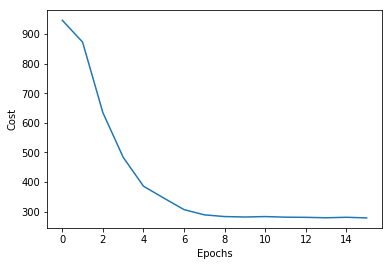

Number of epochs: 18
18
18
18


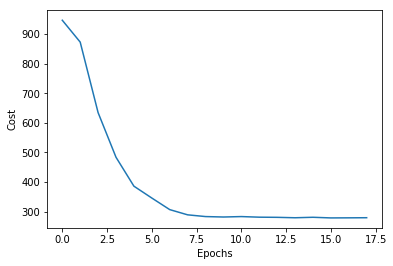

Number of epochs: 20
20
20
20


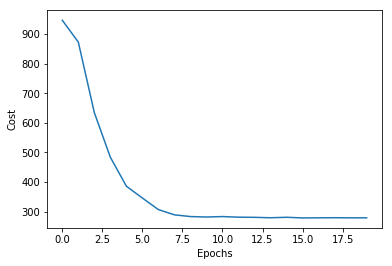

[72, 113, 36, 22, 28, 55, 40, 61, 114, 87, 68, 73, 74, 84, 103, 38, 3, 17, 21, 105, 25, 45, 13, 130, 125, 9, 54, 108, 97, 67, 65, 10, 24, 48, 76, 100, 37, 35, 89, 81, 49, 122, 51, 36, 122, 104, 104, 63]
['I', 'I', 'I', 'Q', 'N', ' ', 'I', 'I', 'I', 'I', 'I']
Predicted: IIIQN IIIII
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
16.0
['I', 'I', 'I', 'Q', 'S', 'L', ' ', 'I', 'I', 'I', 'I', 'I']
Predicted: IIIQSL IIIII
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.5
['I', 'I', ' ', 'I', 'M', 'J', ' ', 'Z', 'V', ' ', 'I', 'I', 'I', 'I', 'I']
Predicted: II IMJ ZV IIIII
Ground truth: P L E A S A N T H I L L S
WER: 
5.25
['I', 'I', 'I', 'F', 'N', 'J', 'O', ' ', 'I', 'I', 'I', 'I', 'I']
Predicted: IIIFNJO IIIII
Ground truth: E R I C
WER: 
5.5
['I', 'I', 'I', 'V', 'O', 'J', 'W', 'A', 'N', ' ', 'I', 'I', 'I', 'I', 'I']
Predicted: IIIVOJWAN IIIII
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['I', ' ', 'I', 'I', 'K', 'V', ' ', 'I', 'I', 'I', 'I', ' ', ' ', 'I']
Predicted: I

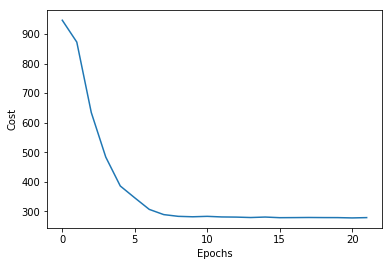

Number of epochs: 24
24
24
24


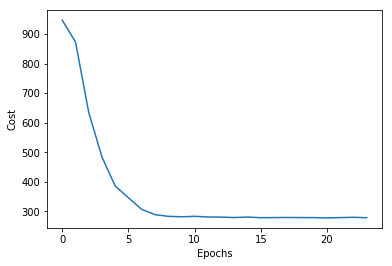

Number of epochs: 26
26
26
26


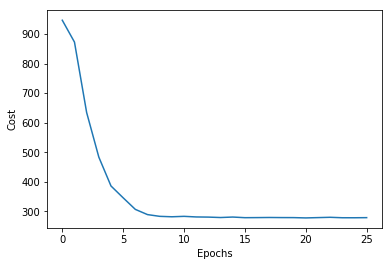

Number of epochs: 28
28
28
28


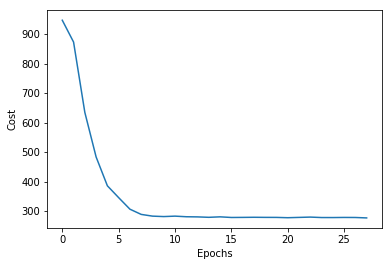

Number of epochs: 30
30
30
30


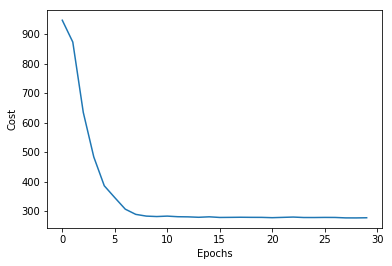

[12, 83, 90, 126, 19, 82, 35, 58, 61, 115, 33, 9, 116, 109, 65, 29, 43, 120, 36, 59, 3, 48, 86, 1, 10, 29, 94, 69, 49, 125, 103, 18, 114, 55, 108, 107, 107, 55, 112, 120, 68, 29, 42, 29, 118, 126, 95, 108]
['I', 'I', 'I', 'Q', 'N', ' ', 'I', 'I', 'I', 'I', 'I']
Predicted: IIIQN IIIII
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
16.0
['I', 'I', 'I', 'Q', ' ', 'M', ' ', 'I', 'I', 'I', 'I', 'I']
Predicted: IIIQ M IIIII
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
11.666666666666666
['I', 'I', 'I', 'Q', 'J', ' ', 'Z', 'F', ' ', 'I', 'I', 'I', 'I', 'I']
Predicted: IIIQJ ZF IIIII
Ground truth: P L E A S A N T H I L L S
WER: 
7.333333333333333
['I', 'I', 'I', 'H', 'E', 'J', 'O', ' ', 'I', 'I', 'I', 'I', 'I']
Predicted: IIIHEJO IIIII
Ground truth: E R I C
WER: 
5.0
['I', 'I', 'I', 'V', 'O', 'J', ' ', 'A', 'N', ' ', 'I', 'I', 'I', 'I', 'I']
Predicted: IIIVOJ AN IIIII
Ground truth: ENTER NINE TWO EIGHT
WER: 
5.666666666666667
['I', ' ', 'I', 'I', 'K', 'V', ' ', 'I', 'I',

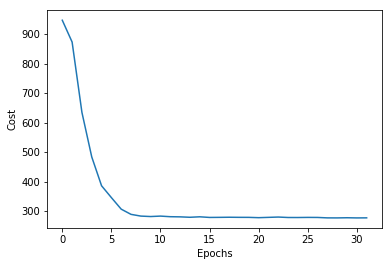

Number of epochs: 34
34
34
34


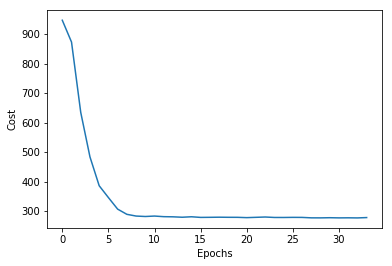

Number of epochs: 36
36
36
36


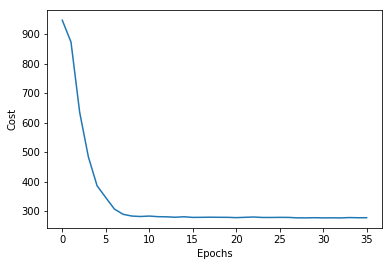

Number of epochs: 38
38
38
38


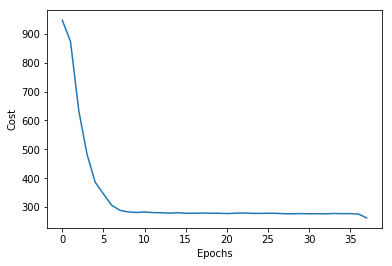

Number of epochs: 40
40
40
40


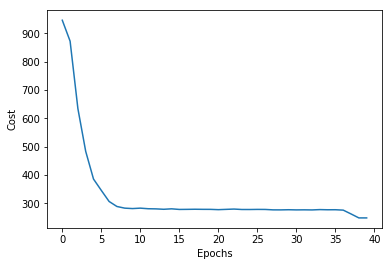

[117, 4, 86, 61, 1, 57, 49, 95, 25, 36, 92, 90, 94, 103, 27, 44, 85, 119, 46, 66, 114, 30, 119, 60, 39, 39, 111, 64, 20, 4, 70, 2, 84, 97, 44, 79, 45, 34, 111, 68, 67, 127, 66, 58, 65, 104, 1, 7]
['I', 'I', 'I', ' ', 'Q', 'N', ' ', 'I', 'I', 'I', 'I']
Predicted: III QN IIII
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
10.333333333333334
['I', 'I', 'I', 'V', 'S', 'D', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIVSD IIII
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.0
['I', ' ', 'I', 'I', 'Q', 'J', ' ', 'Z', 'F', ' ', 'I', 'I', 'I', 'I']
Predicted: I IIQJ ZF IIII
Ground truth: P L E A S A N T H I L L S
WER: 
5.25
['I', 'I', 'I', 'H', 'S', 'J', 'O', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIHSJO IIII
Ground truth: E R I C
WER: 
5.0
['I', 'I', 'I', 'V', 'O', 'J', ' ', 'C', 'N', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIVOJ CN IIII
Ground truth: ENTER NINE TWO EIGHT
WER: 
5.666666666666667
['I', ' ', 'I', 'I', 'Q', 'V', ' ', 'I', 'I', 'I', ' ', 'I']
Predicted: I IIQV III I
G

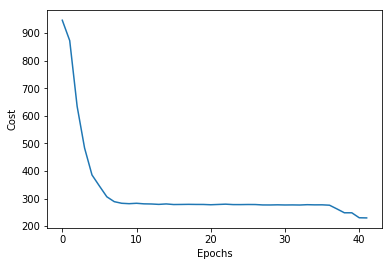

Number of epochs: 44
44
44
44


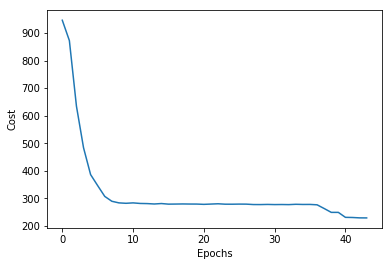

Number of epochs: 46
46
46
46


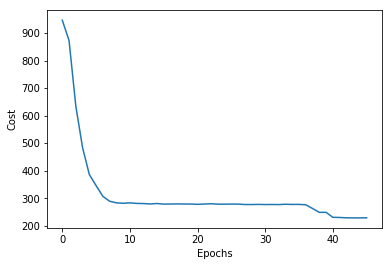

Number of epochs: 48
48
48
48


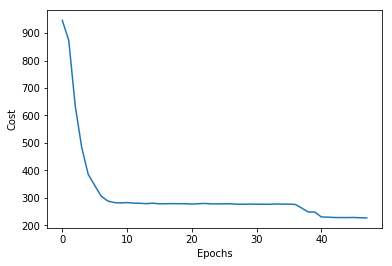

Number of epochs: 50
50
50
50


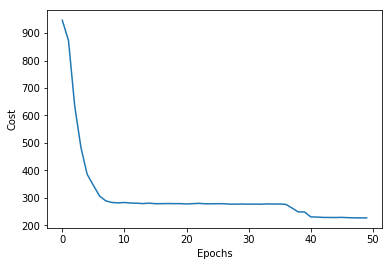

[44, 87, 63, 68, 88, 5, 45, 61, 64, 111, 13, 108, 51, 127, 46, 18, 24, 14, 42, 125, 122, 102, 18, 108, 62, 114, 18, 45, 0, 38, 117, 96, 69, 18, 69, 114, 116, 56, 87, 67, 69, 94, 41, 87, 12, 90, 17, 92]
['G', 'G', 'G', 'G', ' ', 'Q', 'B', ' ', 'G', 'G', ' ', 'G', 'G']
Predicted: GGGG QB GG GG
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
8.25
['I', 'I', 'I', 'I', 'V', 'S', 'D', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIIVSD IIII
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.0
['I', 'I', 'I', 'I', 'Q', 'V', ' ', 'Z', 'F', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIIQV ZF IIII
Ground truth: P L E A S A N T H I L L S
WER: 
7.333333333333333
['I', 'I', 'I', 'I', 'H', 'S', 'J', 'O', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIIHSJO IIII
Ground truth: E R I C
WER: 
5.5
['I', 'I', 'I', 'I', 'W', 'O', 'J', 'B', 'C', 'D', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIIWOJBCD IIII
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['I', 'I', 'I', 'I', 'Q', 'P', 'Z', ' ', 'I', 'I', 'I', 'I']
Pred

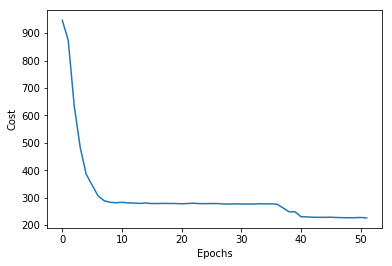

Number of epochs: 54
54
54
54


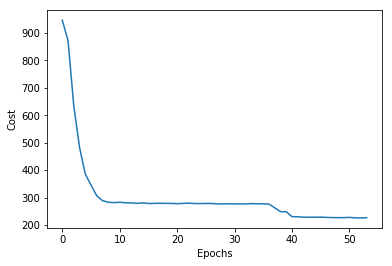

Number of epochs: 56
56
56
56


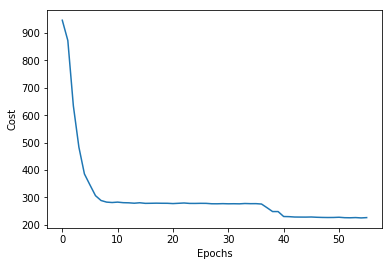

Number of epochs: 58
58
58
58


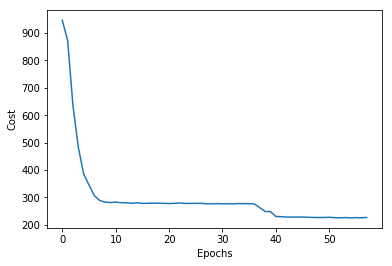

Number of epochs: 60
60
60
60


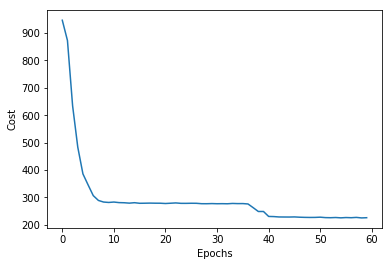

[20, 19, 95, 24, 37, 39, 26, 74, 1, 17, 37, 36, 93, 106, 116, 120, 74, 63, 68, 74, 90, 21, 95, 48, 60, 129, 123, 35, 22, 120, 26, 114, 52, 79, 52, 53, 52, 17, 77, 29, 61, 60, 59, 69, 44, 39, 57, 119]
['G', 'G', 'G', 'G', ' ', 'F', 'B', ' ', 'G', 'G', ' ', 'G', 'G']
Predicted: GGGG FB GG GG
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
8.25
['I', 'I', 'I', 'I', 'Q', 'S', 'D', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIIQSD IIII
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.5
['I', 'I', 'I', 'I', 'S', 'V', 'B', 'Z', 'F', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIISVBZF IIII
Ground truth: P L E A S A N T H I L L S
WER: 
11.0
['G', 'G', 'G', 'G', 'H', 'S', 'J', 'B', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGHSJB GGGG
Ground truth: E R I C
WER: 
6.0
['G', 'G', 'G', 'G', 'W', 'O', 'J', 'B', 'D', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGWOJBD GGGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
9.0
['I', 'I', 'I', 'I', 'Q', 'V', 'Z', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIIQVZ IIII
G

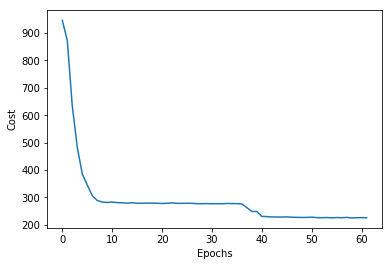

Number of epochs: 64
64
64
64


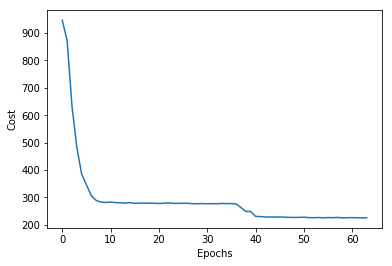

Number of epochs: 66
66
66
66


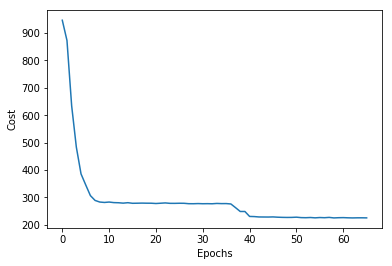

Number of epochs: 68
68
68
68


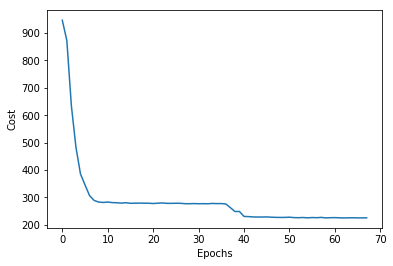

Number of epochs: 70
70
70
70


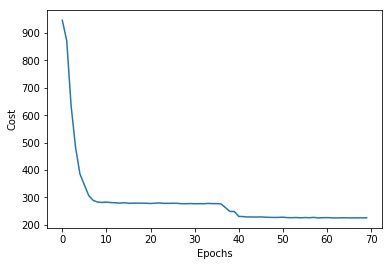

[129, 112, 68, 89, 95, 65, 11, 65, 32, 50, 34, 0, 127, 26, 69, 83, 81, 2, 97, 104, 71, 1, 3, 105, 7, 46, 93, 78, 6, 35, 100, 20, 107, 6, 0, 103, 110, 112, 80, 62, 86, 114, 64, 100, 16, 97, 80, 51]
['G', 'G', 'G', 'G', ' ', 'F', 'B', ' ', 'G', 'G', ' ', 'G', 'G']
Predicted: GGGG FB GG GG
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
8.25
['I', 'I', 'I', 'I', 'V', 'S', 'D', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIIVSD IIII
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.0
['G', 'G', 'G', 'G', 'S', 'V', 'B', 'Z', 'F', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGSVBZF GGGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'G', 'G', 'G', 'H', 'A', 'D', 'B', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGHADB GGGG
Ground truth: E R I C
WER: 
6.0
['G', 'G', 'G', 'G', 'W', 'O', 'J', 'B', 'D', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGWOJBD GGGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
9.0
['G', 'G', 'G', 'G', 'Q', 'V', 'Z', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGQVZ GGGG
Grou

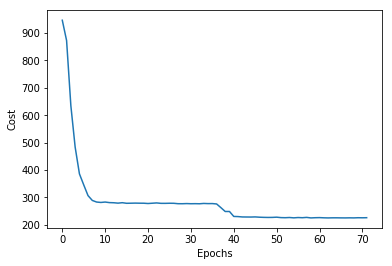

Number of epochs: 74
74
74
74


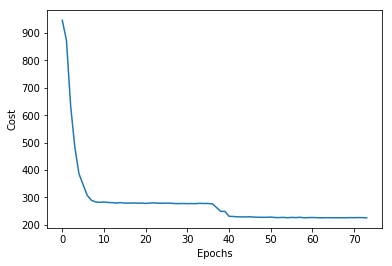

Number of epochs: 76
76
76
76


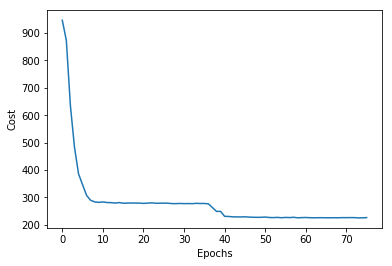

Number of epochs: 78
78
78
78


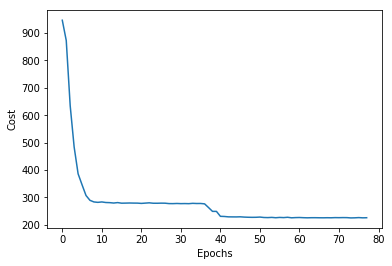

Number of epochs: 80
80
80
80


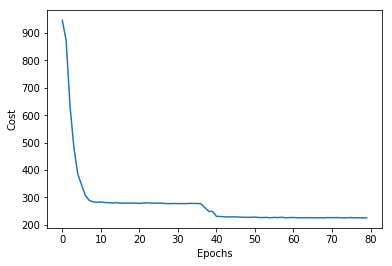

[98, 1, 109, 26, 21, 130, 43, 86, 127, 16, 96, 88, 41, 99, 73, 19, 14, 95, 20, 42, 27, 85, 127, 102, 124, 79, 119, 23, 51, 34, 97, 23, 118, 68, 0, 35, 112, 7, 84, 45, 93, 121, 1, 106, 97, 58, 35, 7]
['I', 'I', 'I', 'I', ' ', 'F', 'M', ' ', 'I', 'I', ' ', 'I', 'I']
Predicted: IIII FM II II
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
7.75
['G', 'G', 'G', 'G', 'V', 'S', 'D', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGVSD GGGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.0
['G', 'G', 'G', 'G', 'S', 'V', 'B', 'K', 'F', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGSVBKF GGGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'G', 'G', 'G', 'H', 'P', 'D', 'B', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGHPDB GGGG
Ground truth: E R I C
WER: 
6.0
['I', 'I', 'I', 'I', 'W', 'O', 'J', 'B', 'D', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIIWOJBD IIII
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['G', 'G', 'G', 'G', 'Q', 'V', 'Z', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGQVZ GGGG
Gr

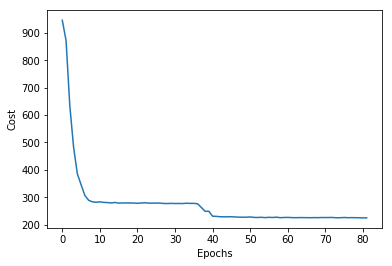

Number of epochs: 84
84
84
84


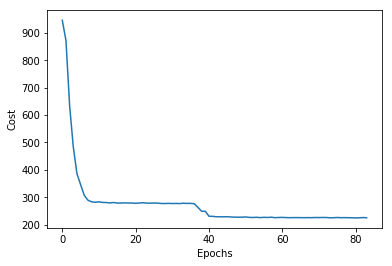

Number of epochs: 86
86
86
86


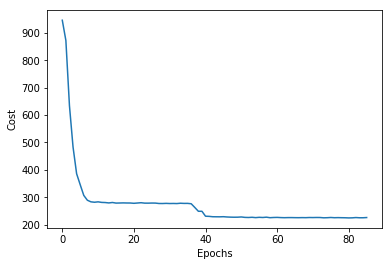

Number of epochs: 88
88
88
88


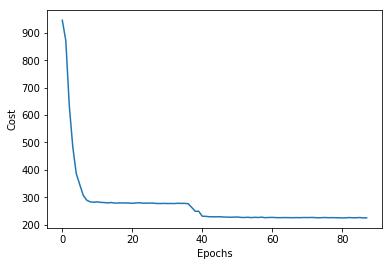

Number of epochs: 90
90
90
90


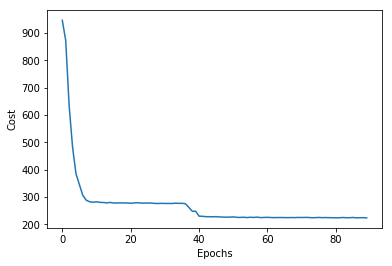

[59, 122, 100, 98, 97, 25, 85, 106, 17, 77, 61, 111, 104, 118, 57, 16, 15, 44, 67, 40, 58, 115, 78, 22, 22, 20, 102, 8, 40, 100, 95, 7, 93, 10, 129, 17, 19, 4, 70, 122, 79, 118, 8, 75, 90, 39, 111, 40]
['G', 'G', 'G', 'G', ' ', 'F', 'M', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGG FM GGGG
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
11.333333333333334
['G', 'G', 'G', 'G', 'Q', 'S', 'D', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGQSD GGGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.5
['G', 'G', 'G', 'G', 'S', 'V', 'B', 'K', 'F', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGSVBKF GGGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'G', 'G', 'G', 'H', 'P', 'D', 'Q', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGHPDQ GGGG
Ground truth: E R I C
WER: 
6.0
['I', 'I', 'I', 'I', 'W', 'O', 'J', 'B', 'D', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIIWOJBD IIII
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['G', 'G', 'G', 'G', 'Q', 'V', 'Z', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGG

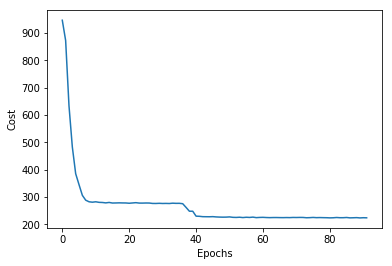

Number of epochs: 94
94
94
94


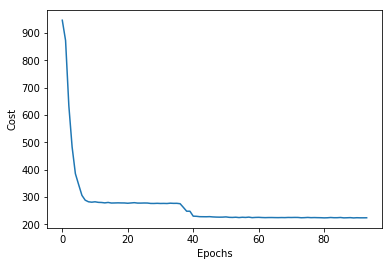

Number of epochs: 96
96
96
96


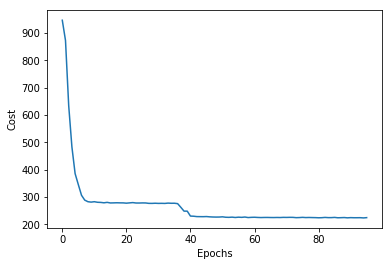

Number of epochs: 98
98
98
98


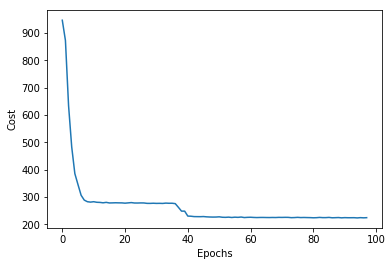

Number of epochs: 100
100
100
100


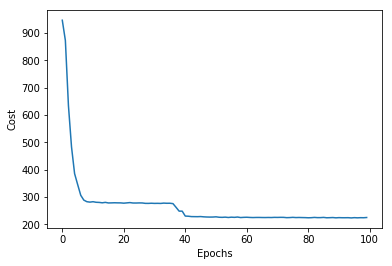

[14, 42, 97, 120, 104, 24, 113, 83, 35, 105, 37, 7, 124, 108, 84, 70, 92, 84, 89, 126, 83, 16, 74, 130, 107, 50, 96, 122, 61, 87, 111, 30, 70, 114, 113, 17, 38, 126, 3, 93, 20, 105, 59, 54, 70, 107, 115, 82]
['G', 'G', 'G', 'G', ' ', 'F', 'M', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGG FM GGGG
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
11.333333333333334
['G', 'G', 'G', 'G', 'V', 'S', 'D', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGVSD GGGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.0
['G', 'G', 'G', 'G', 'S', 'V', 'B', 'K', 'F', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGSVBKF GGGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['I', 'I', 'I', 'I', 'H', 'D', 'Q', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIIHDQ IIII
Ground truth: E R I C
WER: 
5.0
['G', 'G', 'G', 'G', 'W', 'F', 'L', 'B', 'W', 'D', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGWFLBWD GGGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['G', 'G', 'G', 'G', 'Q', 'V', 'Z', ' ', 'G', 'G', 'G', 'G']
Predicted

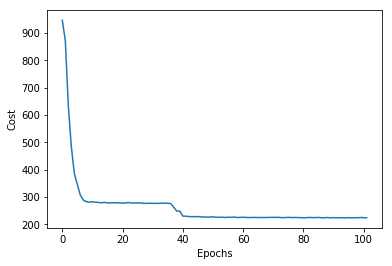

Number of epochs: 104
104
104
104


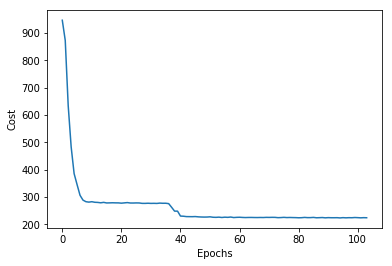

Number of epochs: 106
106
106
106


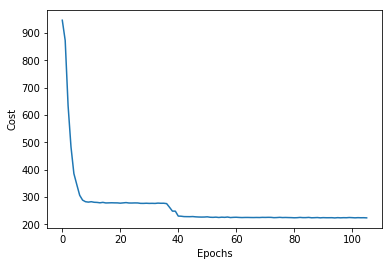

Number of epochs: 108
108
108
108


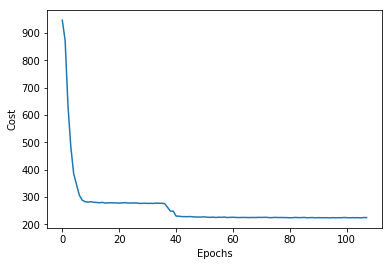

Number of epochs: 110
110
110
110


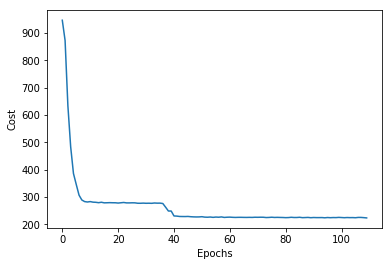

[4, 2, 118, 101, 60, 5, 100, 76, 99, 73, 119, 10, 37, 20, 105, 2, 86, 55, 73, 57, 61, 43, 67, 36, 23, 56, 103, 33, 82, 30, 130, 57, 11, 121, 64, 68, 99, 36, 82, 20, 110, 79, 113, 28, 78, 73, 109, 118]
['G', 'G', 'G', 'G', ' ', 'F', 'K', ' ', 'G', 'G', ' ', 'G', 'G']
Predicted: GGGG FK GG GG
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
8.25
['I', 'I', 'I', 'I', 'V', 'S', 'D', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIIVSD IIII
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.0
['I', 'I', 'I', 'I', 'S', 'W', 'B', 'K', 'C', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIISWBKC IIII
Ground truth: P L E A S A N T H I L L S
WER: 
11.0
['G', 'G', 'G', 'G', 'C', 'P', 'K', 'Q', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGCPKQ GGGG
Ground truth: E R I C
WER: 
6.0
['G', 'G', 'G', 'G', 'W', 'F', 'L', 'B', 'W', 'D', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGWFLBWD GGGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['I', 'I', 'I', 'I', 'Q', 'B', 'Z', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIIQBZ

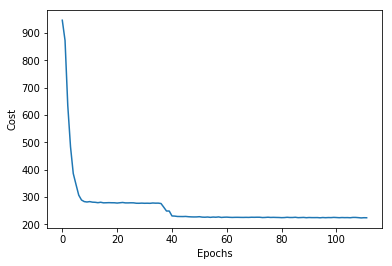

Number of epochs: 114
114
114
114


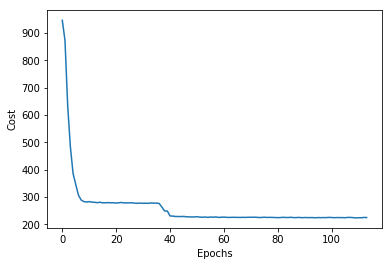

Number of epochs: 116
116
116
116


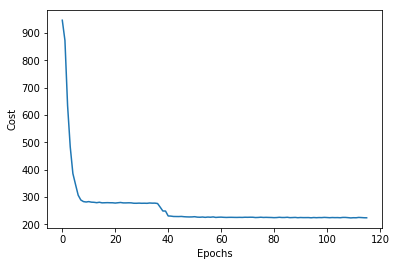

Number of epochs: 118
118
118
118


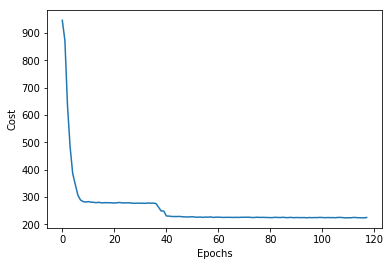

Number of epochs: 120
120
120
120


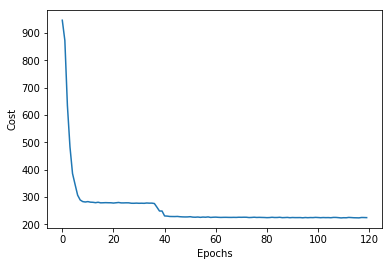

[93, 47, 75, 64, 67, 30, 74, 127, 9, 50, 121, 5, 93, 120, 35, 47, 26, 97, 89, 109, 96, 39, 112, 16, 22, 45, 72, 41, 102, 12, 118, 33, 57, 48, 7, 49, 50, 61, 13, 113, 102, 33, 3, 43, 53, 12, 32, 123]
['G', 'G', 'G', 'G', ' ', 'F', 'K', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGG FK GGGG
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
11.333333333333334
['I', 'I', 'I', 'I', 'V', 'S', 'J', ' ', 'I', 'I', 'I', 'I']
Predicted: IIIIVSJ IIII
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.0
['G', 'G', 'G', 'G', 'S', 'W', 'B', 'K', 'C', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGSWBKC GGGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'G', 'G', 'G', 'C', 'P', 'K', 'Q', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGCPKQ GGGG
Ground truth: E R I C
WER: 
6.0
['G', 'G', 'G', 'G', 'W', 'M', 'L', 'B', 'W', 'D', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGWMLBWD GGGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['G', 'G', 'G', 'G', 'Q', 'B', 'Z', ' ', 'G', 'G', 'G', 'G']
Predicted: G

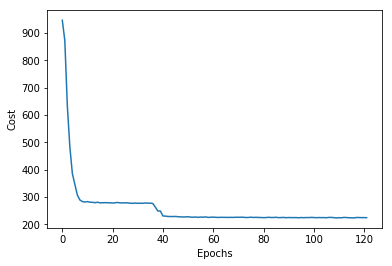

Number of epochs: 124
124
124
124


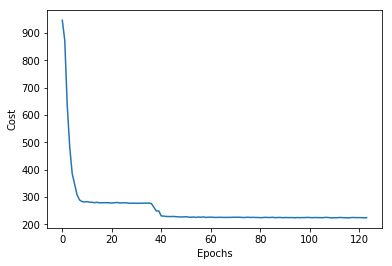

Number of epochs: 126
126
126
126


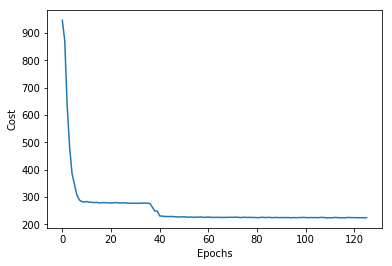

Number of epochs: 128
128
128
128


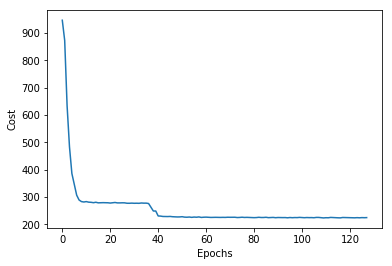

Number of epochs: 130
130
130
130


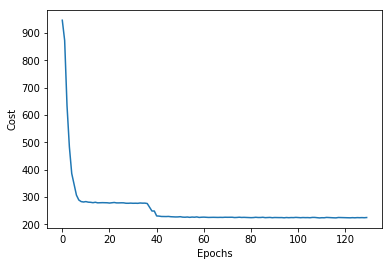

[83, 61, 35, 86, 120, 64, 124, 44, 80, 31, 20, 2, 66, 33, 24, 33, 93, 39, 97, 94, 53, 28, 108, 18, 82, 55, 46, 125, 88, 4, 44, 116, 7, 94, 40, 85, 109, 57, 6, 15, 16, 105, 86, 20, 78, 9, 10, 80]
['X', 'X', 'X', 'X', ' ', 'C', 'K', ' ', 'X', 'X', ' ', 'X', 'X']
Predicted: XXXX CK XX XX
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
8.0
['X', 'X', 'X', 'X', 'V', 'S', 'J', ' ', 'X', 'X', 'X', 'X']
Predicted: XXXXVSJ XXXX
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.0
['X', 'X', 'X', 'X', 'S', 'W', 'B', 'K', 'C', ' ', 'X', 'X', 'X', 'X']
Predicted: XXXXSWBKC XXXX
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['X', 'X', 'X', 'X', 'C', 'P', 'K', 'Q', ' ', 'X', 'X', 'X', 'X']
Predicted: XXXXCPKQ XXXX
Ground truth: E R I C
WER: 
6.0
['X', 'X', 'X', 'X', 'W', 'Q', 'L', 'B', 'W', 'D', ' ', 'X', 'X', 'X', 'X']
Predicted: XXXXWQLBWD XXXX
Ground truth: ENTER NINE TWO EIGHT
WER: 
9.0
['X', 'X', 'X', 'X', 'Q', 'V', 'Z', ' ', 'X', 'X', 'X', 'X']
Predicted: XXXXQVZ XXXX
G

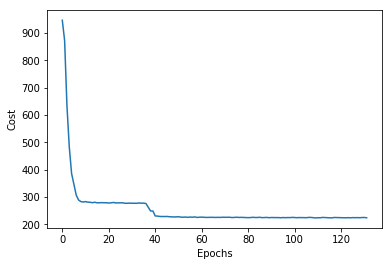

Number of epochs: 134
134
134
134


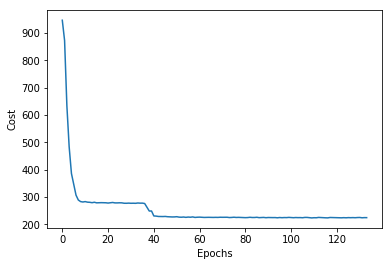

Number of epochs: 136
136
136
136


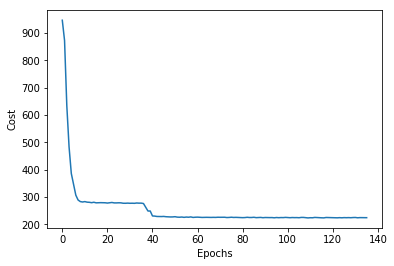

Number of epochs: 138
138
138
138


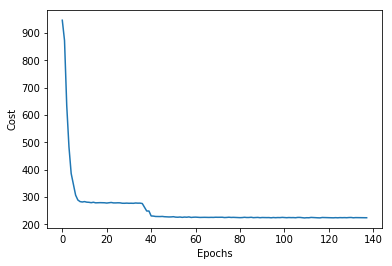

Number of epochs: 140
140
140
140


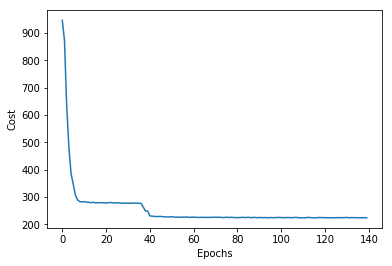

[17, 118, 3, 19, 127, 1, 12, 127, 97, 112, 85, 26, 19, 31, 6, 41, 109, 91, 3, 111, 73, 120, 59, 59, 86, 103, 98, 110, 110, 37, 1, 91, 35, 89, 77, 21, 130, 79, 28, 61, 13, 50, 79, 16, 9, 48, 40, 49]
['G', 'G', 'G', 'G', ' ', 'C', 'K', ' ', 'G', 'G', ' ', 'G', 'G']
Predicted: GGGG CK GG GG
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
8.25
['G', 'G', 'G', 'G', 'V', 'S', 'J', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGVSJ GGGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.0
['G', 'G', 'G', 'G', 'S', 'W', 'B', 'K', 'C', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGSWBKC GGGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'G', 'G', 'G', 'H', 'P', 'K', 'Q', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGHPKQ GGGG
Ground truth: E R I C
WER: 
6.0
['G', 'G', 'G', 'G', 'W', 'Q', 'L', 'B', 'W', 'D', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGWQLBWD GGGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['G', 'G', 'G', 'G', 'Q', 'V', 'Z', ' ', 'G', 'G', 'G', 'G']
Predicted: GGGGQVZ GG

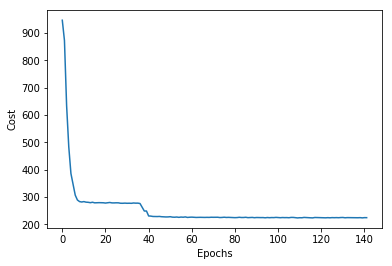

Number of epochs: 144
144
144
144


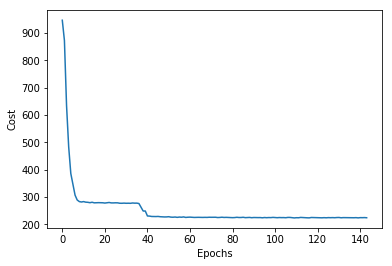

Number of epochs: 146
146
146
146


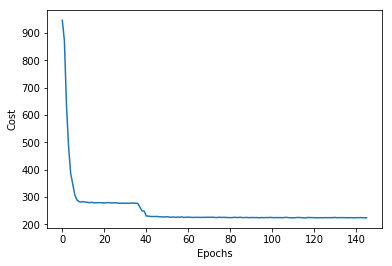

Number of epochs: 148
148
148
148


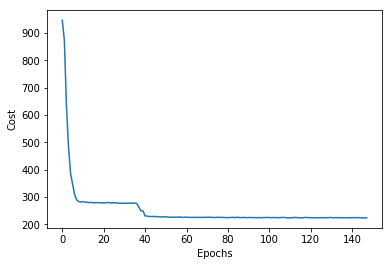

Number of epochs: 150
150
150
150


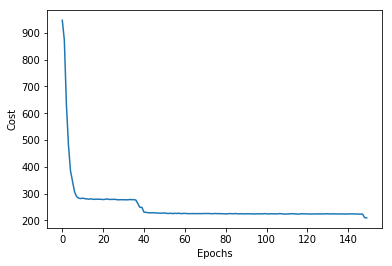

[33, 80, 64, 59, 45, 2, 66, 20, 14, 32, 55, 75, 58, 86, 130, 66, 43, 34, 29, 128, 55, 124, 18, 90, 18, 16, 116, 87, 30, 101, 112, 78, 34, 50, 11, 72, 116, 96, 113, 108, 72, 91, 22, 57, 17, 9, 28, 86]
['G', 'G', 'G', 'G', ' ', 'C', 'K', ' ', 'G', 'S', 'G', 'G', 'N']
Predicted: GGGG CK GSGGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
10.666666666666666
['G', 'G', 'G', 'G', 'V', 'S', 'J', ' ', 'G', 'G', 'G']
Predicted: GGGGVSJ GGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.0
['G', 'G', 'G', 'G', 'S', 'W', 'B', 'Z', 'C', ' ', 'G', 'G', 'G']
Predicted: GGGGSWBZC GGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'G', 'G', 'G', 'B', 'P', 'W', 'Q', ' ', 'G', 'G', 'G']
Predicted: GGGGBPWQ GGG
Ground truth: E R I C
WER: 
5.5
['G', 'G', 'G', 'G', 'W', 'Q', 'L', 'K', 'W', 'A', ' ', 'G', 'G', 'G']
Predicted: GGGGWQLKWA GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['G', 'G', 'G', 'G', 'Q', 'V', 'M', ' ', 'G', 'G', 'G']
Predicted: GGGGQVM GGG
Ground trut

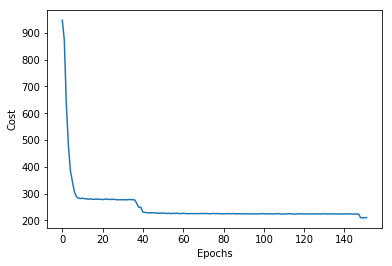

Number of epochs: 154
154
154
154


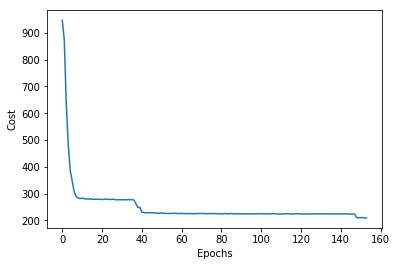

Number of epochs: 156
156
156
156


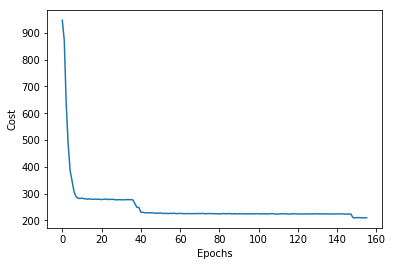

Number of epochs: 158
158
158
158


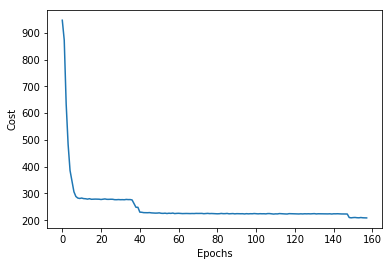

Number of epochs: 160
160
160
160


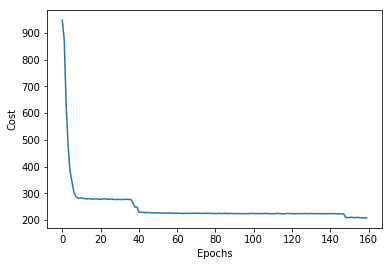

[11, 108, 28, 81, 79, 108, 11, 55, 127, 36, 23, 7, 92, 30, 82, 24, 21, 108, 7, 69, 47, 124, 59, 64, 109, 49, 0, 20, 72, 11, 22, 2, 120, 20, 73, 10, 52, 96, 63, 23, 63, 105, 71, 34, 66, 61, 55, 126]
['G', 'G', 'G', 'G', ' ', 'C', 'K', 'N', 'G', 'N', 'S', 'G', 'G', 'N']
Predicted: GGGG CKNGNSGGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
15.5
['G', 'G', 'G', 'G', 'W', 'S', 'J', ' ', 'G', 'G', 'G']
Predicted: GGGGWSJ GGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.5
['G', 'G', 'G', 'G', 'S', 'W', 'B', 'O', 'C', ' ', 'G', 'G', 'G']
Predicted: GGGGSWBOC GGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'G', 'G', 'G', 'B', 'P', 'W', 'Q', ' ', 'G', 'G', 'G']
Predicted: GGGGBPWQ GGG
Ground truth: E R I C
WER: 
5.5
['G', 'G', 'G', 'G', 'W', 'Q', 'L', 'K', 'W', 'A', ' ', 'G', 'G', 'G']
Predicted: GGGGWQLKWA GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['G', 'G', 'G', 'G', 'Q', 'V', 'M', ' ', 'G', 'G', 'G']
Predicted: GGGGQVM GGG
Ground truth: K A U F

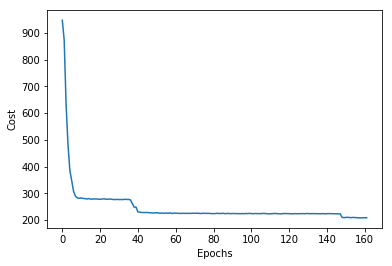

Number of epochs: 164
164
164
164


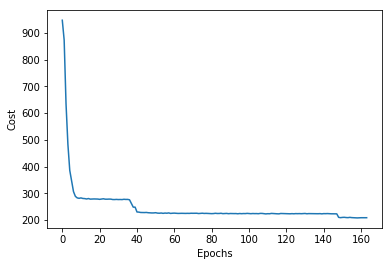

Number of epochs: 166
166
166
166


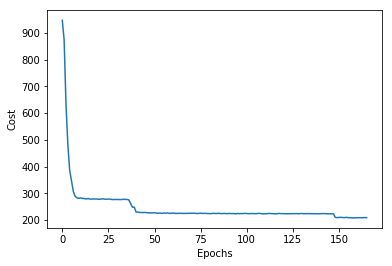

Number of epochs: 168
168
168
168


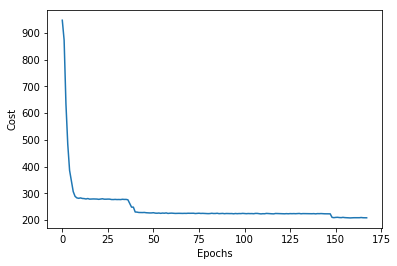

Number of epochs: 170
170
170
170


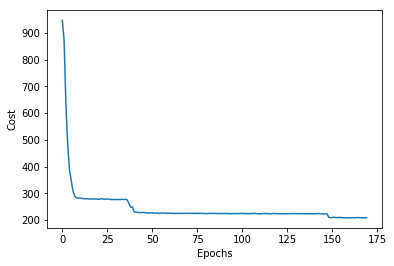

[84, 81, 50, 130, 92, 130, 105, 100, 27, 116, 88, 103, 67, 107, 87, 48, 58, 64, 93, 87, 30, 32, 117, 66, 44, 65, 38, 72, 4, 71, 73, 98, 102, 96, 29, 76, 58, 40, 69, 9, 118, 61, 54, 27, 75, 44, 77, 75]
['G', 'G', 'G', 'G', ' ', 'C', 'B', 'N', 'G', 'N', 'S', 'G', 'G', 'N']
Predicted: GGGG CBNGNSGGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
15.5
['G', 'G', 'G', 'G', 'W', 'E', 'J', ' ', 'G', 'G', 'G']
Predicted: GGGGWEJ GGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.5
['G', 'G', 'G', 'G', 'S', 'W', 'B', 'O', 'C', ' ', 'G', 'G', 'G']
Predicted: GGGGSWBOC GGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'G', 'G', 'G', 'B', 'P', 'W', 'Q', ' ', 'G', 'G', 'G']
Predicted: GGGGBPWQ GGG
Ground truth: E R I C
WER: 
5.5
['G', 'G', 'G', 'G', 'W', 'Q', 'L', 'K', 'W', 'A', ' ', 'G', 'G', 'G']
Predicted: GGGGWQLKWA GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['G', 'G', 'G', 'G', 'Q', 'V', 'B', ' ', 'G', 'G', 'G']
Predicted: GGGGQVB GGG
Ground truth: K A 

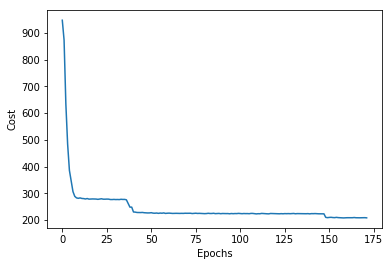

Number of epochs: 174
174
174
174


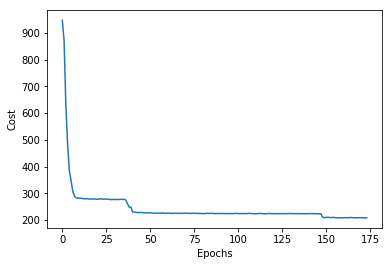

Number of epochs: 176
176
176
176


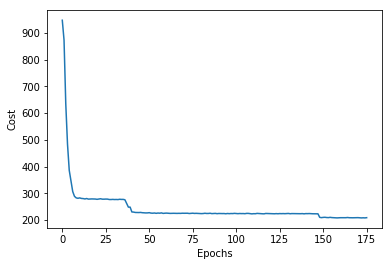

Number of epochs: 178
178
178
178


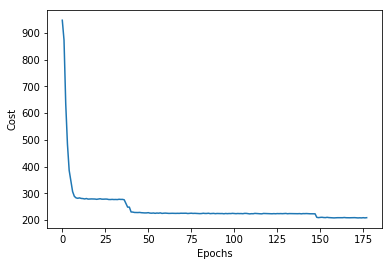

Number of epochs: 180
180
180
180


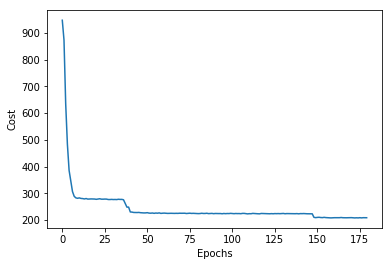

[82, 126, 74, 95, 49, 71, 54, 92, 84, 38, 11, 96, 62, 127, 9, 69, 98, 60, 79, 97, 3, 114, 35, 37, 72, 108, 28, 71, 8, 40, 65, 13, 18, 28, 5, 130, 74, 123, 20, 97, 31, 130, 91, 99, 75, 56, 72, 28]
['G', 'G', 'G', 'T', 'G', ' ', 'C', 'B', 'V', 'N', 'G', 'N', 'S', 'G', 'G', 'N']
Predicted: GGGTG CBVNGNSGGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
15.0
['G', 'G', 'G', 'G', 'W', 'E', 'J', ' ', 'G', 'G', 'G']
Predicted: GGGGWEJ GGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.5
['G', 'G', 'G', 'G', 'S', 'R', 'B', 'O', 'C', ' ', 'G', 'G', 'G']
Predicted: GGGGSRBOC GGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'G', 'G', 'G', 'Y', 'K', 'Y', 'Q', ' ', 'G', 'G', 'G']
Predicted: GGGGYKYQ GGG
Ground truth: E R I C
WER: 
5.5
['G', 'G', 'G', 'G', 'W', 'Q', 'L', 'K', 'W', 'A', ' ', 'G', 'G', 'G']
Predicted: GGGGWQLKWA GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['G', 'G', 'G', 'G', ' ', 'Q', 'K', 'B', ' ', 'G', 'G', 'G']
Predicted: GGGG QKB GGG
Groun

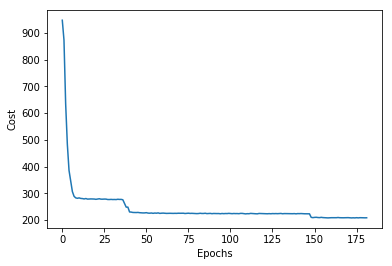

Number of epochs: 184
184
184
184


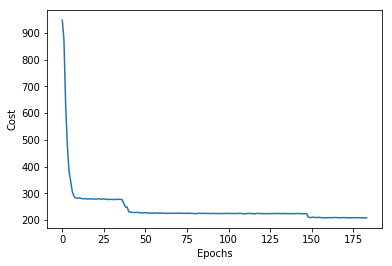

Number of epochs: 186
186
186
186


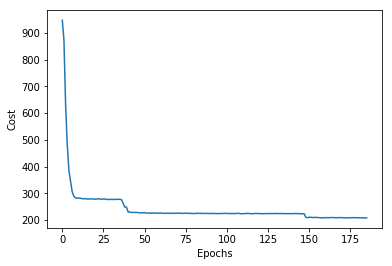

Number of epochs: 188
188
188
188


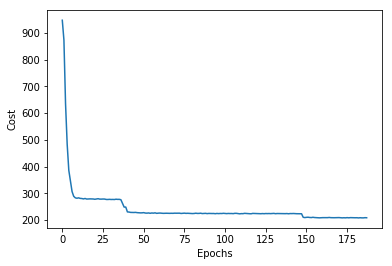

Number of epochs: 190
190
190
190


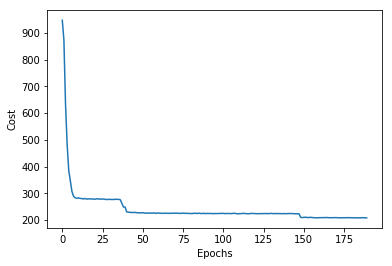

[99, 87, 15, 107, 23, 88, 120, 39, 60, 125, 90, 16, 12, 10, 103, 1, 87, 54, 118, 61, 94, 125, 9, 106, 66, 33, 102, 101, 124, 22, 92, 124, 10, 98, 48, 70, 84, 29, 58, 92, 17, 1, 85, 119, 127, 130, 66, 15]
['G', 'G', 'G', 'T', 'G', ' ', 'C', 'B', 'V', 'G', 'S', 'G', 'G', 'N']
Predicted: GGGTG CBVGSGGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
16.0
['G', 'G', 'G', 'G', 'W', 'E', 'J', ' ', 'G', 'G', 'G']
Predicted: GGGGWEJ GGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.5
['G', 'G', 'G', 'G', 'S', ' ', 'B', 'O', 'C', ' ', 'G', 'G', 'G']
Predicted: GGGGS BOC GGG
Ground truth: P L E A S A N T H I L L S
WER: 
7.333333333333333
['G', 'G', 'G', 'G', 'Y', 'K', 'E', 'Q', ' ', 'G', 'G', 'G']
Predicted: GGGGYKEQ GGG
Ground truth: E R I C
WER: 
5.5
['G', 'G', 'G', 'G', ' ', 'Q', 'L', 'K', ' ', 'A', ' ', 'G', 'G', 'G']
Predicted: GGGG QLK A GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
4.0
['G', 'G', 'G', 'G', ' ', 'Q', 'K', 'B', ' ', 'G', 'G', 'G']
Predicted: GGGG QKB 

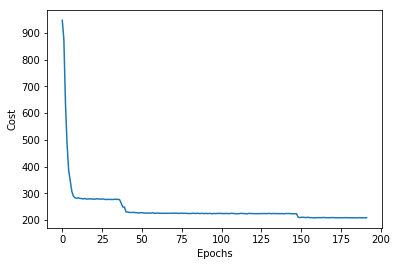

Number of epochs: 194
194
194
194


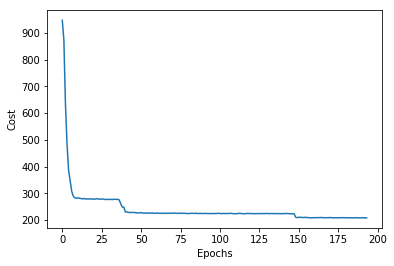

Number of epochs: 196
196
196
196


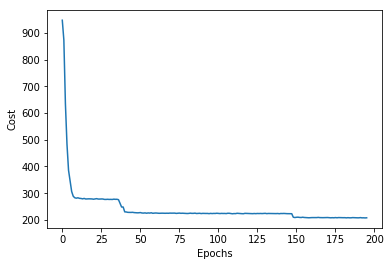

Number of epochs: 198
198
198
198


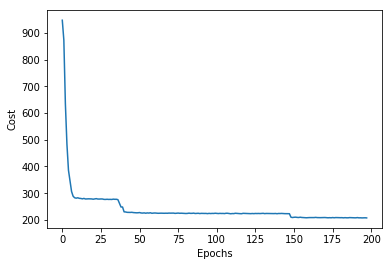

Number of epochs: 200
200
200
200


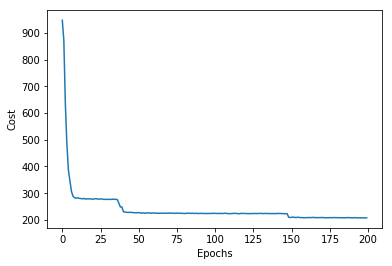

[91, 124, 117, 66, 1, 101, 61, 70, 94, 99, 105, 39, 2, 74, 29, 83, 34, 61, 101, 4, 38, 74, 74, 0, 123, 90, 21, 49, 30, 107, 86, 79, 119, 51, 88, 90, 89, 94, 50, 110, 120, 14, 24, 94, 100, 49, 2, 114]
['I', 'I', 'I', 'T', 'I', ' ', 'C', 'A', 'V', 'I', 'S', 'I', 'I', 'N']
Predicted: IIITI CAVISIIN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
15.0
['I', 'I', 'I', 'I', 'H', 'E', 'J', ' ', 'I', 'I', 'I']
Predicted: IIIIHEJ III
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
17.5
['I', 'I', 'I', 'I', 'S', 'R', 'B', 'O', 'C', ' ', 'I', 'I', 'I']
Predicted: IIIISRBOC III
Ground truth: P L E A S A N T H I L L S
WER: 
11.0
['I', 'I', 'I', 'I', 'Y', 'P', 'Y', 'Q', ' ', 'I', 'I', 'I']
Predicted: IIIIYPYQ III
Ground truth: E R I C
WER: 
5.0
['I', 'I', 'I', 'I', 'Z', 'Q', 'L', 'P', ' ', 'A', ' ', 'I', 'I', 'I']
Predicted: IIIIZQLP A III
Ground truth: ENTER NINE TWO EIGHT
WER: 
5.666666666666667
['I', 'I', 'I', 'I', ' ', 'C', 'K', 'B', ' ', 'I', 'I', 'I']
Predicted: IIII CKB III

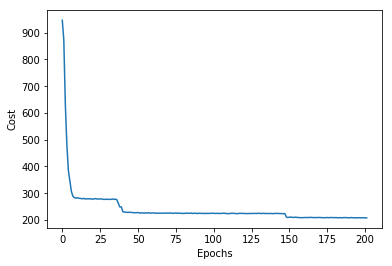

Number of epochs: 204
204
204
204


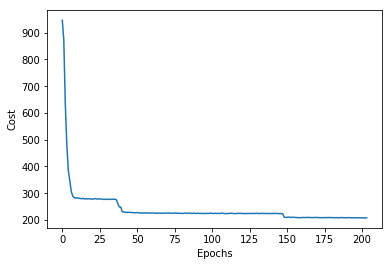

Number of epochs: 206
206
206
206


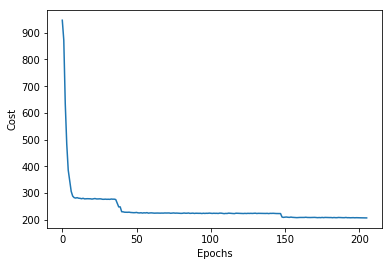

Number of epochs: 208
208
208
208


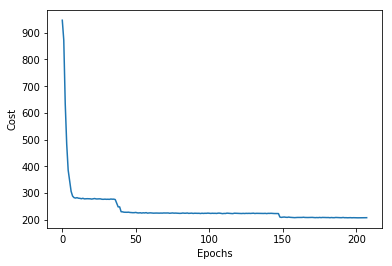

Number of epochs: 210
210
210
210


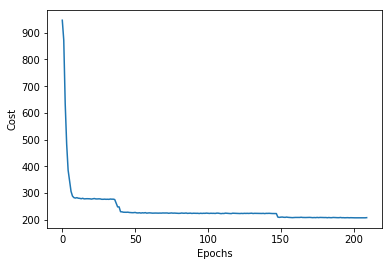

[124, 15, 14, 98, 7, 98, 10, 77, 107, 82, 112, 76, 112, 13, 79, 78, 24, 85, 112, 57, 15, 76, 126, 16, 94, 111, 85, 15, 115, 56, 31, 48, 75, 23, 72, 22, 50, 122, 28, 44, 126, 44, 9, 78, 124, 31, 8, 39]
['G', 'G', 'G', 'T', 'G', ' ', 'C', 'A', 'V', 'G', ' ', 'S', 'G', 'G', 'N']
Predicted: GGGTG CAVG SGGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
10.333333333333334
['G', 'G', 'G', 'G', 'H', ' ', 'J', ' ', 'G', 'G', 'G']
Predicted: GGGGH J GGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
11.666666666666666
['G', 'G', 'G', 'G', 'S', 'R', 'B', 'O', 'C', ' ', 'G', 'G', 'G']
Predicted: GGGGSRBOC GGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'G', 'G', 'G', 'L', 'P', 'Y', 'Q', ' ', 'G', 'G', 'G']
Predicted: GGGGLPYQ GGG
Ground truth: E R I C
WER: 
5.5
['G', 'G', 'G', 'G', ' ', 'Q', 'L', 'P', ' ', 'A', ' ', 'G', 'G', 'G']
Predicted: GGGG QLP A GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
4.0
['G', 'G', 'G', 'G', ' ', 'C', 'K', 'B', ' ', 'G', 'G', 'G']
Pr

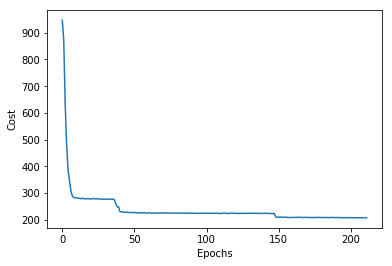

Number of epochs: 214
214
214
214


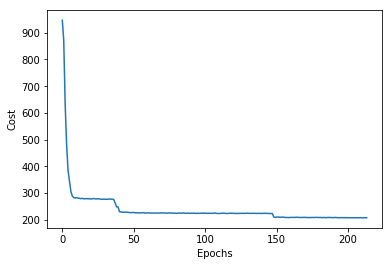

Number of epochs: 216
216
216
216


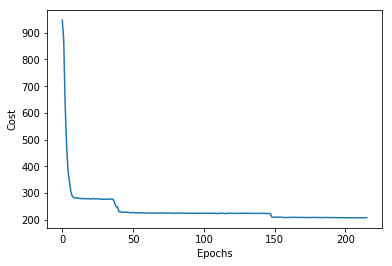

Number of epochs: 218
218
218
218


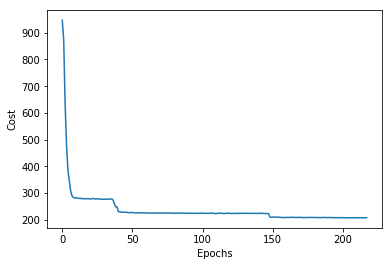

Number of epochs: 220
220
220
220


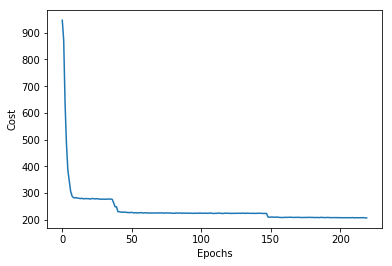

[46, 84, 93, 43, 40, 112, 103, 42, 108, 10, 128, 85, 85, 80, 45, 25, 74, 93, 98, 4, 110, 68, 53, 89, 85, 86, 124, 93, 19, 104, 126, 37, 31, 68, 103, 104, 116, 101, 12, 82, 44, 74, 28, 57, 111, 10, 26, 105]
['G', 'G', 'G', 'T', 'G', ' ', 'C', 'A', 'V', 'N', 'G', ' ', 'S', 'G', 'G', 'N']
Predicted: GGGTG CAVNG SGGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
10.0
['G', 'G', 'G', 'G', ' ', 'J', ' ', 'G', 'G', 'G']
Predicted: GGGG J GGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
11.666666666666666
['G', 'G', 'G', 'G', 'S', 'R', 'B', 'W', 'A', ' ', 'G', 'G', 'G']
Predicted: GGGGSRBWA GGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'G', 'G', 'G', 'L', 'P', 'Y', 'Q', ' ', 'G', 'G', 'G']
Predicted: GGGGLPYQ GGG
Ground truth: E R I C
WER: 
5.5
['G', 'G', 'G', 'G', 'Z', 'Q', 'L', 'P', ' ', 'P', ' ', 'G', 'G', 'G']
Predicted: GGGGZQLP P GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
5.666666666666667
['G', 'G', 'G', 'G', ' ', 'C', 'K', 'B', ' ', 'G', 'G', 'G

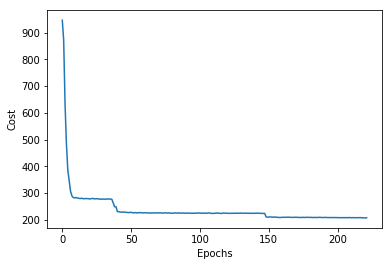

Number of epochs: 224
224
224
224


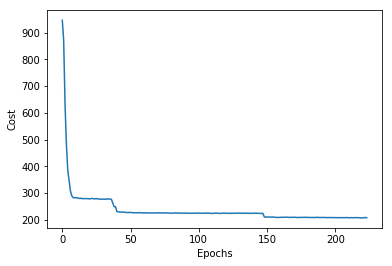

Number of epochs: 226
226
226
226


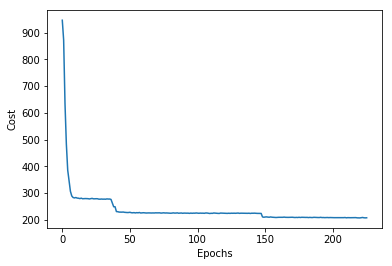

Number of epochs: 228
228
228
228


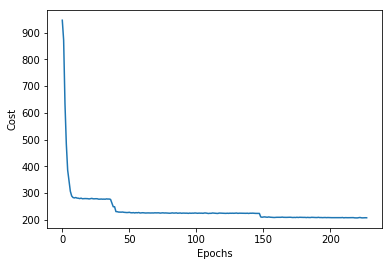

Number of epochs: 230
230
230
230


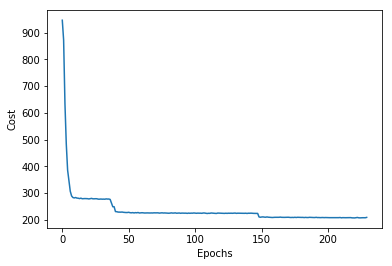

[77, 72, 73, 90, 23, 104, 39, 85, 125, 65, 4, 100, 6, 53, 56, 29, 65, 81, 19, 66, 41, 38, 99, 20, 100, 31, 99, 120, 9, 15, 16, 61, 100, 106, 128, 24, 126, 36, 75, 26, 108, 36, 2, 82, 7, 70, 67, 1]
['G', 'G', ' ', ' ', 'G', 'T', 'G', ' ', 'C', 'A', 'V', 'N', 'G', ' ', ' ', 'S', 'G', 'R', 'G', 'N']
Predicted: GG  GTG CAVNG  SGRGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
7.25
['G', 'G', 'G', 'G', ' ', 'A', 'Q', ' ', 'G', 'G', 'G']
Predicted: GGGG AQ GGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
11.666666666666666
['G', 'G', 'G', 'G', 'S', 'R', 'B', 'W', 'A', ' ', 'G', 'G', 'G']
Predicted: GGGGSRBWA GGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'G', 'G', 'G', 'L', 'P', 'Y', 'Q', ' ', 'G', 'N', 'G', 'G']
Predicted: GGGGLPYQ GNGG
Ground truth: E R I C
WER: 
6.0
['G', 'G', 'G', 'G', 'Z', 'Q', 'L', 'P', ' ', 'P', ' ', 'G', 'G', 'G']
Predicted: GGGGZQLP P GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
5.666666666666667
['G', 'G', 'G', 'G', ' ', 'W', 

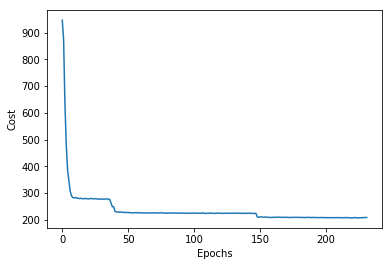

Number of epochs: 234
234
234
234


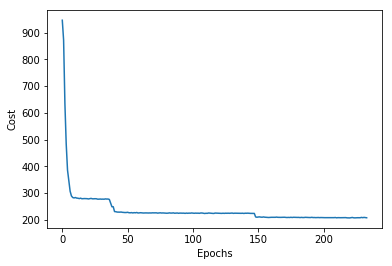

Number of epochs: 236
236
236
236


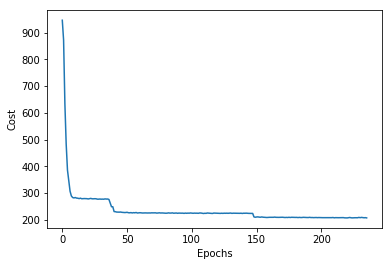

Number of epochs: 238
238
238
238


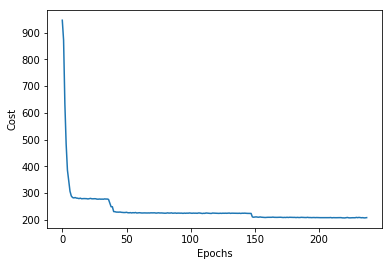

Number of epochs: 240
240
240
240


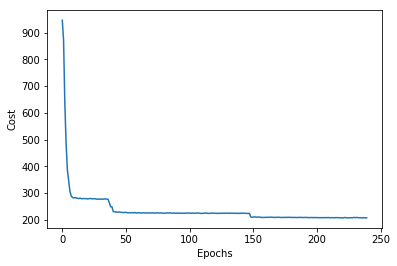

[100, 3, 50, 112, 96, 34, 116, 130, 12, 39, 66, 91, 96, 115, 72, 68, 6, 58, 75, 21, 56, 30, 89, 68, 70, 93, 93, 2, 66, 40, 9, 89, 129, 17, 6, 16, 40, 64, 2, 1, 48, 30, 77, 21, 3, 75, 118, 115]
['G', 'G', ' ', ' ', 'G', ' ', 'G', ' ', 'C', 'A', 'V', 'N', 'G', ' ', ' ', 'S', 'G', 'G', 'N']
Predicted: GG  G G CAVNG  SGGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
5.8
['G', 'G', 'G', 'G', ' ', 'A', 'C', ' ', 'G', 'G', 'G']
Predicted: GGGG AC GGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
11.666666666666666
['G', 'G', 'G', 'G', 'S', 'R', 'B', 'W', 'A', ' ', 'G', 'G', 'G']
Predicted: GGGGSRBWA GGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'G', 'G', 'G', 'L', 'P', 'Y', 'Q', ' ', 'G', 'N', 'G', 'G', 'N']
Predicted: GGGGLPYQ GNGGN
Ground truth: E R I C
WER: 
6.5
['G', 'G', 'G', 'G', 'F', 'D', 'L', 'E', ' ', 'P', ' ', 'G', 'G', 'G']
Predicted: GGGGFDLE P GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
5.333333333333333
['G', 'G', 'G', 'G', ' ', 'W', 'K', 

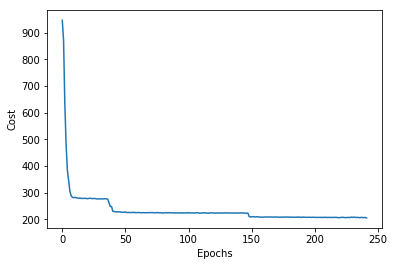

Number of epochs: 244
244
244
244


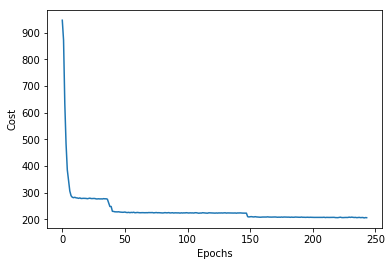

Number of epochs: 246
246
246
246


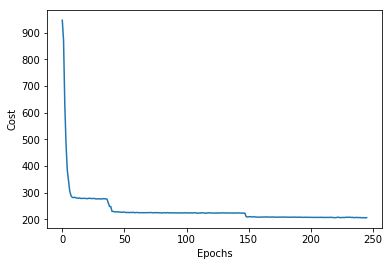

Number of epochs: 248
248
248
248


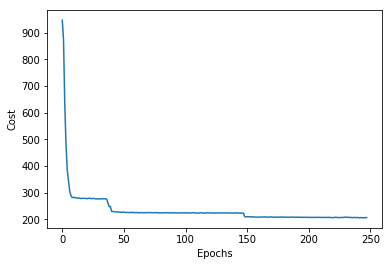

Number of epochs: 250
250
250
250


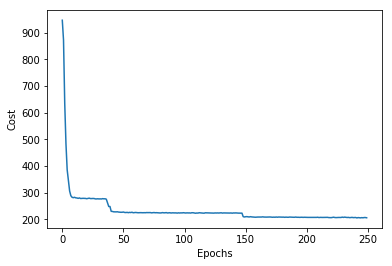

[42, 1, 55, 50, 121, 75, 58, 49, 116, 26, 58, 35, 54, 4, 108, 78, 58, 38, 5, 89, 71, 36, 74, 119, 102, 40, 72, 89, 28, 121, 21, 6, 50, 101, 122, 108, 82, 12, 12, 82, 67, 12, 36, 47, 19, 41, 66, 78]
['G', 'G', ' ', ' ', 'G', ' ', 'S', 'G', ' ', 'F', 'A', 'V', 'S', 'G', ' ', ' ', 'S', 'G', 'G', 'N']
Predicted: GG  G SG FAVSG  SGGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
5.8
['G', 'G', 'G', 'G', ' ', 'A', 'C', ' ', 'G', 'G', 'G']
Predicted: GGGG AC GGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
11.666666666666666
['G', 'G', 'G', 'G', 'S', 'R', 'B', 'W', 'A', ' ', 'G', 'G', 'G']
Predicted: GGGGSRBWA GGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'E', 'G', 'G', 'G', 'L', 'P', 'Y', 'J', ' ', 'G', 'N', 'G', 'G']
Predicted: GEGGGLPYJ GNGG
Ground truth: E R I C
WER: 
6.0
['G', 'G', 'G', 'G', ' ', 'J', 'D', 'L', 'E', ' ', 'P', ' ', 'G', 'G', 'G']
Predicted: GGGG JDLE P GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
3.75
['G', 'G', 'G', 'G', ' ', 'W', '

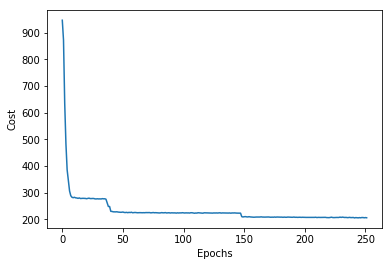

Number of epochs: 254
254
254
254


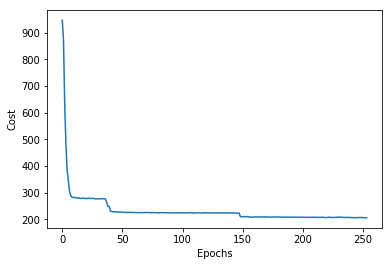

Number of epochs: 256
256
256
256


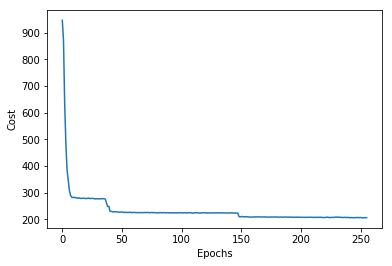

Number of epochs: 258
258
258
258


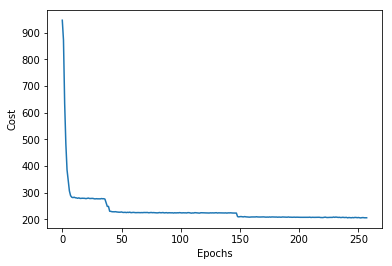

Number of epochs: 260
260
260
260


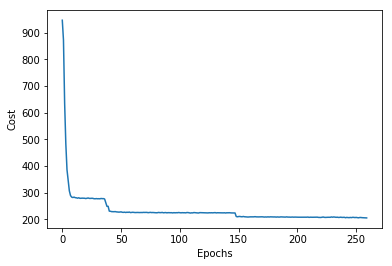

[56, 51, 5, 125, 47, 77, 83, 6, 71, 96, 67, 130, 26, 44, 39, 115, 109, 34, 25, 102, 107, 16, 22, 88, 94, 48, 120, 78, 78, 56, 77, 1, 126, 66, 114, 112, 46, 49, 42, 51, 85, 50, 86, 19, 49, 23, 21, 88]
['I', ' ', 'I', ' ', ' ', 'I', ' ', 'S', 'I', ' ', 'F', 'A', 'V', 'N', 'I', ' ', ' ', 'S', 'I', 'I', 'N']
Predicted: I I  I SI FAVNI  SIIN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
4.666666666666667
['G', 'G', 'G', 'G', ' ', 'A', 'C', ' ', 'G', 'G', 'G']
Predicted: GGGG AC GGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
11.666666666666666
['I', 'I', 'I', 'I', 'Q', 'R', 'B', 'E', 'A', ' ', 'I', 'I', 'I']
Predicted: IIIIQRBEA III
Ground truth: P L E A S A N T H I L L S
WER: 
11.0
['I', 'E', 'I', 'N', 'E', 'I', 'V', 'I', 'L', 'P', 'Y', 'J', ' ', 'I', 'N', 'E', 'I', 'I', 'N']
Predicted: IEINEIVILPYJ INEIIN
Ground truth: E R I C
WER: 
8.0
['I', 'I', 'I', 'I', ' ', 'J', 'D', 'E', ' ', 'P', ' ', 'I', 'I', 'I']
Predicted: IIII JDE P III
Ground truth: ENTER NINE TWO EIG

['G', 'G', 'G', 'G', 'L', 'P', 'Q', ' ', 'S', 'G', 'G', 'G']
Predicted: GGGGLPQ SGGG
Ground truth: P I T T S B U R G H
WER: 
8.0
['I', ' ', ' ', 'I', 'N', ' ', 'I', ' ', 'I', ' ', 'C', 'A', ' ', 'I', 'N', ' ', 'S', 'I', 'I']
Predicted: I  IN I I CA IN SII
Ground truth: ONE FIVE TWO TWO FOUR
WER: 
2.5714285714285716
Number of epochs: 262
262
262
262


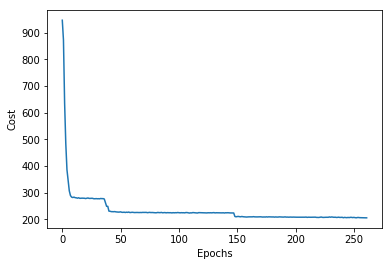

Number of epochs: 264
264
264
264


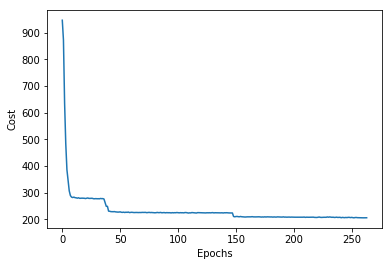

Number of epochs: 266
266
266
266


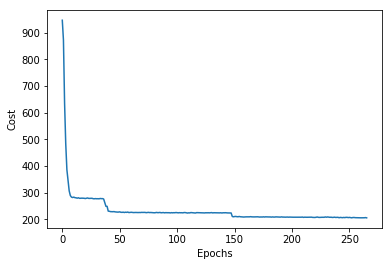

Number of epochs: 268
268
268
268


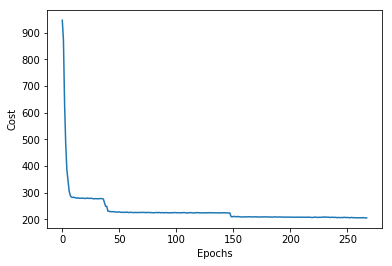

Number of epochs: 270
270
270
270


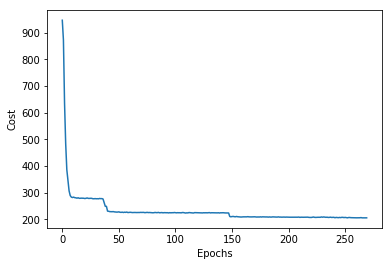

[42, 72, 108, 64, 89, 88, 115, 96, 120, 43, 2, 114, 23, 113, 31, 39, 129, 88, 12, 93, 95, 102, 72, 6, 111, 43, 62, 95, 107, 67, 114, 34, 120, 82, 16, 67, 111, 79, 98, 85, 38, 57, 34, 43, 92, 30, 61, 114]
['G', ' ', 'G', ' ', ' ', 'G', ' ', 'G', ' ', 'F', 'A', 'V', 'S', 'G', ' ', ' ', 'S', 'G', ' ', 'G', 'N']
Predicted: G G  G G FAVSG  SG GN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
4.285714285714286
['G', 'G', 'G', 'G', ' ', 'A', 'C', ' ', 'G', 'G', 'G']
Predicted: GGGG AC GGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
11.666666666666666
['G', 'G', 'G', 'G', 'S', 'R', 'B', 'E', 'A', ' ', 'G', 'G', 'G']
Predicted: GGGGSRBEA GGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'E', 'G', 'N', 'E', 'G', 'V', 'G', 'O', 'P', 'Y', 'J', ' ', 'G', 'N', 'G', 'G']
Predicted: GEGNEGVGOPYJ GNGG
Ground truth: E R I C
WER: 
7.5
['G', 'G', 'G', 'G', 'J', 'D', 'E', ' ', 'P', ' ', 'G', 'G', 'G']
Predicted: GGGGJDE P GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
5.333

Number of epochs: 272
272
272
272


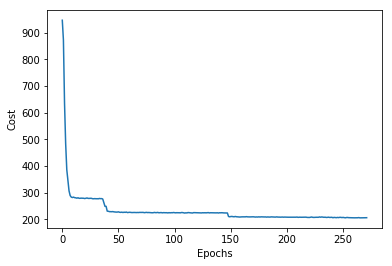

Number of epochs: 274
274
274
274


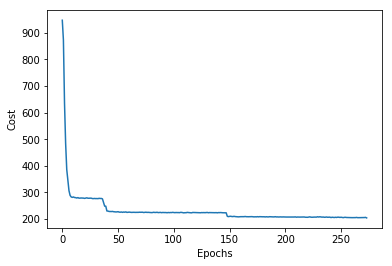

Number of epochs: 276
276
276
276


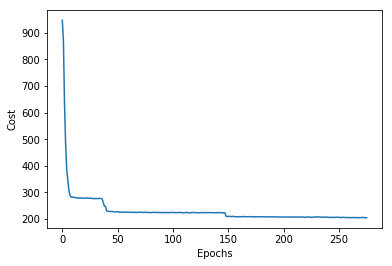

Number of epochs: 278
278
278
278


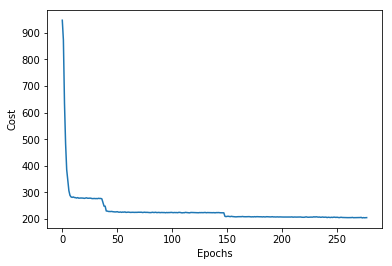

Number of epochs: 280
280
280
280


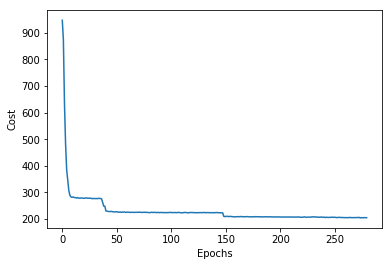

[24, 103, 14, 100, 53, 67, 127, 46, 59, 31, 20, 67, 60, 121, 101, 117, 31, 43, 33, 59, 112, 29, 87, 24, 106, 42, 10, 32, 5, 98, 101, 32, 2, 114, 50, 32, 130, 40, 25, 22, 98, 54, 91, 76, 90, 77, 38, 4]
['G', ' ', 'G', ' ', ' ', 'G', ' ', 'S', 'G', ' ', 'F', 'A', 'V', 'S', 'G', ' ', ' ', 'S', 'G', ' ', 'G', 'N']
Predicted: G G  G SG FAVSG  SG GN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
4.142857142857143
['G', 'G', 'G', 'G', ' ', 'A', 'C', ' ', 'G', 'G', 'G']
Predicted: GGGG AC GGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
11.666666666666666
['G', 'G', 'G', 'G', 'Q', 'R', 'Z', 'E', 'A', ' ', 'G', 'G', 'G']
Predicted: GGGGQRZEA GGG
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['G', 'E', 'G', 'N', 'E', 'E', 'G', 'T', 'G', ' ', 'O', 'P', 'Y', 'J', ' ', 'G', 'N', 'E', 'E', 'E', 'G', 'G', 'N']
Predicted: GEGNEEGTG OPYJ GNEEEGGN
Ground truth: E R I C
WER: 
6.666666666666667
['G', 'G', 'G', 'G', ' ', 'J', 'D', 'T', 'E', ' ', 'P', ' ', 'G', 'G', 'G']
Predicte

['G', 'E', 'G', 'N', 'E', 'F', 'G', 'T', 'E', 'G', ' ', 'B', 'E', 'E', 'G', 'N', 'E', ' ', 'E', 'E', 'G', 'V', 'E', 'G', 'N']
Predicted: GEGNEFGTEG BEEGNE EEGVEGN
Ground truth: MAY SECOND NINETEEN SIXTY FIVE
WER: 
8.666666666666666
['G', 'E', 'G', 'E', 'E', 'G', 'T', 'G', ' ', 'Q', 'R', ' ', 'G', 'N', ' ', 'E', 'E', 'G', 'T', 'E', 'G', 'N']
Predicted: GEGEEGTG QR GN EEGTEGN
Ground truth: ONE FIVE TWO THREE SIX
WER: 
4.75
['G', 'G', 'G', 'G', 'L', 'P', 'Q', ' ', 'P', 'G', 'G', 'G']
Predicted: GGGGLPQ PGGG
Ground truth: P I T T S B U R G H
WER: 
8.5
['G', ' ', ' ', 'G', ' ', ' ', 'G', ' ', 'G', ' ', 'J', 'A', ' ', 'G', ' ', ' ', 'S', 'G', 'G']
Predicted: G  G  G G JA G  SGG
Ground truth: ONE FIVE TWO TWO FOUR
WER: 
2.5714285714285716
Number of epochs: 282
282
282
282


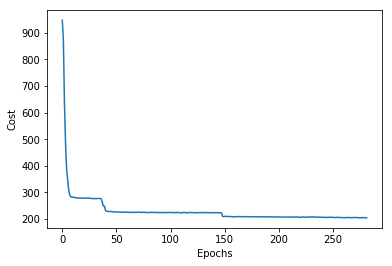

Number of epochs: 284
284
284
284


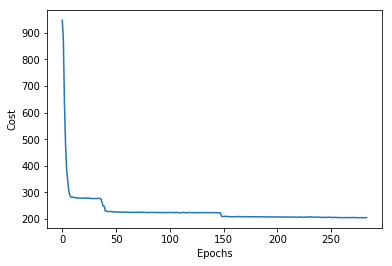

Number of epochs: 286
286
286
286


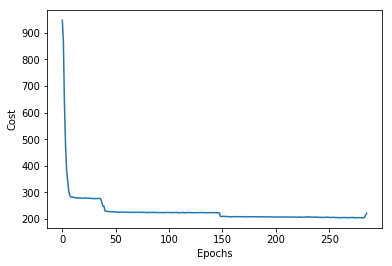

Number of epochs: 288
288
288
288


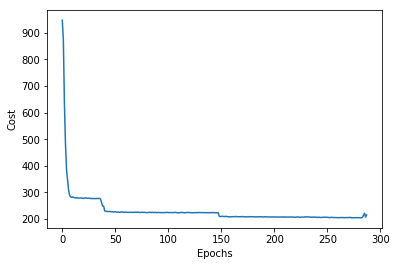

Number of epochs: 290
290
290
290


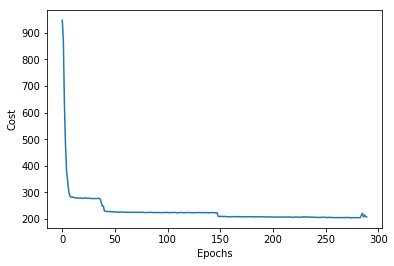

[122, 93, 23, 25, 126, 92, 127, 40, 29, 25, 103, 7, 31, 126, 35, 79, 89, 11, 37, 50, 50, 75, 123, 111, 112, 98, 65, 108, 81, 44, 92, 91, 53, 6, 113, 74, 100, 44, 37, 101, 34, 99, 126, 80, 92, 60, 5, 99]
['G', 'G', 'G', ' ', 'G', ' ', 'F', ' ', 'V', 'G', ' ', 'S', 'G', 'G', 'N']
Predicted: GGG G F VG SGGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
6.0
['G', 'G', 'G', 'G', ' ', 'A', 'C', ' ', 'G', 'G', 'G']
Predicted: GGGG AC GGG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
11.666666666666666
['G', 'G', 'G', 'G', 'K', 'R', 'Z', 'E', 'A', 'O', 'G', 'G', 'G']
Predicted: GGGGKRZEAOGGG
Ground truth: P L E A S A N T H I L L S
WER: 
24.0
['G', 'G', 'G', 'G', ' ', 'P', 'E', 'J', ' ', 'G', 'E', 'G', 'G']
Predicted: GGGG PEJ GEGG
Ground truth: E R I C
WER: 
3.6666666666666665
['G', 'G', 'G', 'G', 'J', 'D', ' ', 'E', ' ', 'G', 'G', 'G']
Predicted: GGGGJD E GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
5.666666666666667
['G', 'G', 'G', 'G', ' ', 'W', 'K', ' ', 'G', ' ', 'G

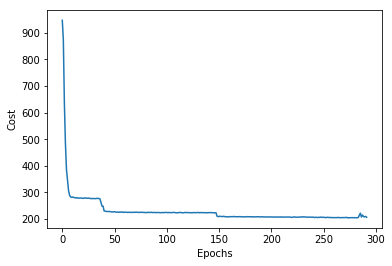

Number of epochs: 294
294
294
294


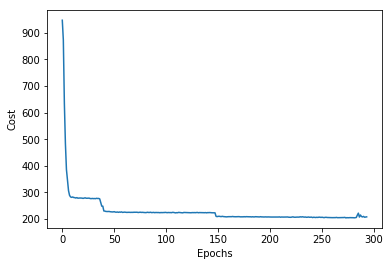

Number of epochs: 296
296
296
296


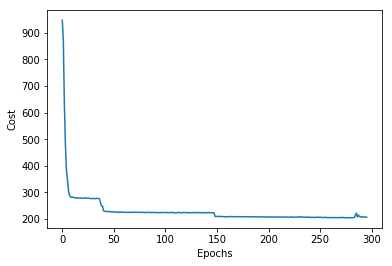

Number of epochs: 298
298
298
298


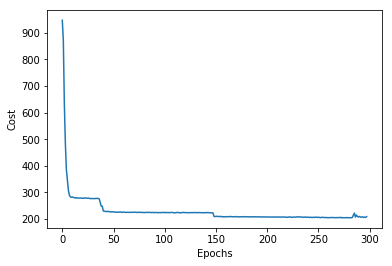

Number of epochs: 300
300
300
300


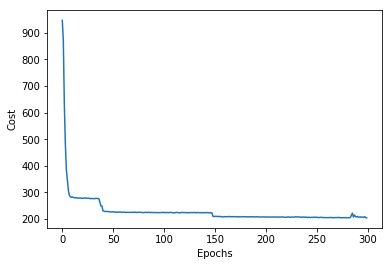

[113, 103, 128, 27, 50, 108, 57, 102, 114, 34, 9, 127, 120, 53, 127, 12, 52, 6, 15, 63, 1, 83, 94, 29, 91, 50, 24, 129, 58, 108, 81, 88, 37, 76, 41, 17, 68, 34, 67, 21, 89, 7, 109, 25, 104, 95, 69, 82]
['G', 'G', 'G', ' ', 'G', ' ', 'F', ' ', 'V', 'G', ' ', 'S', 'G', 'G', 'N']
Predicted: GGG G F VG SGGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
6.0
['G', 'G', 'G', 'G', ' ', 'A', 'C', ' ', 'G', ' ', 'G', 'G']
Predicted: GGGG AC G GG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
8.5
['G', 'G', 'G', 'G', 'K', 'R', 'Z', 'E', 'A', 'O', 'G', 'G', 'G']
Predicted: GGGGKRZEAOGGG
Ground truth: P L E A S A N T H I L L S
WER: 
24.0
['G', 'G', 'G', 'T', 'G', ' ', 'P', 'E', 'J', ' ', 'G', 'E', 'G', 'G']
Predicted: GGGTG PEJ GEGG
Ground truth: E R I C
WER: 
4.0
['G', 'G', 'G', 'G', 'J', 'D', 'O', 'E', ' ', 'G', 'G', 'G']
Predicted: GGGGJDOE GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['G', 'E', 'G', 'G', 'G', ' ', 'W', 'K', ' ', 'G', ' ', 'G', 'E', 'G']
Predicted: GEGG

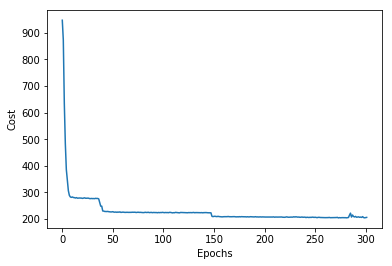

Number of epochs: 304
304
304
304


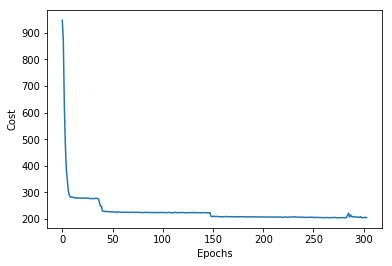

Number of epochs: 306
306
306
306


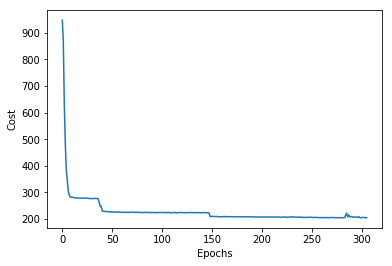

Number of epochs: 308
308
308
308


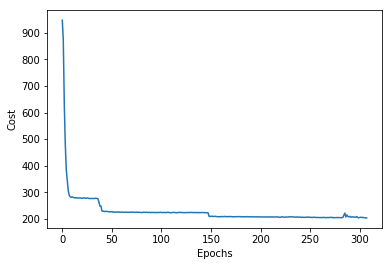

Number of epochs: 310
310
310
310


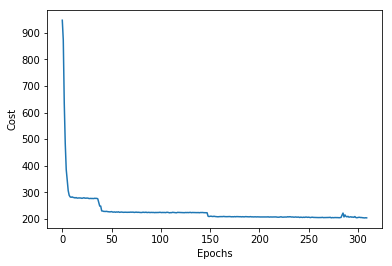

[60, 95, 119, 28, 62, 123, 101, 106, 53, 67, 102, 99, 69, 83, 8, 74, 105, 46, 113, 112, 44, 79, 64, 96, 21, 79, 50, 13, 62, 25, 46, 87, 46, 115, 99, 112, 65, 11, 65, 101, 97, 56, 19, 76, 34, 56, 121, 98]
['G', 'G', 'G', ' ', 'G', ' ', 'F', ' ', 'V', 'G', ' ', 'S', 'G', 'G', 'N']
Predicted: GGG G F VG SGGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
6.0
['G', 'G', 'G', 'G', ' ', 'A', 'C', ' ', 'G', ' ', 'G', 'G']
Predicted: GGGG AC G GG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
8.5
['G', 'G', 'G', 'G', 'K', 'R', 'Z', 'E', 'A', 'O', 'G', 'G', 'G']
Predicted: GGGGKRZEAOGGG
Ground truth: P L E A S A N T H I L L S
WER: 
24.0
['G', 'G', 'G', 'V', 'G', 'O', 'P', 'E', 'J', ' ', 'G', 'E', 'G', 'G']
Predicted: GGGVGOPEJ GEGG
Ground truth: E R I C
WER: 
6.5
['G', 'G', 'G', 'G', 'F', 'D', 'O', 'E', ' ', 'G', 'G', 'G']
Predicted: GGGGFDOE GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['G', 'G', 'G', 'G', ' ', 'Y', 'K', ' ', 'G', ' ', 'G', ' ', 'G']
Predicted: GGGG YK

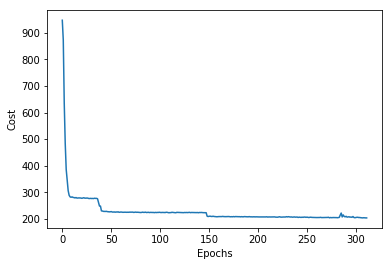

Number of epochs: 314
314
314
314


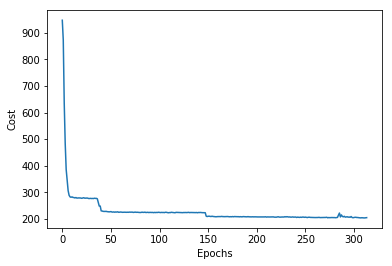

Number of epochs: 316
316
316
316


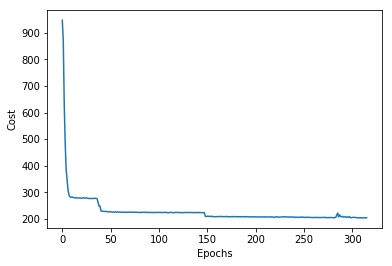

Number of epochs: 318
318
318
318


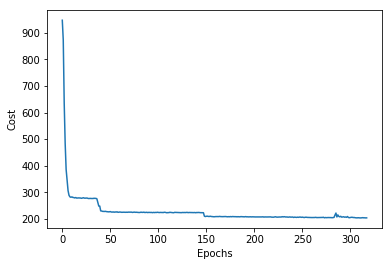

Number of epochs: 320
320
320
320


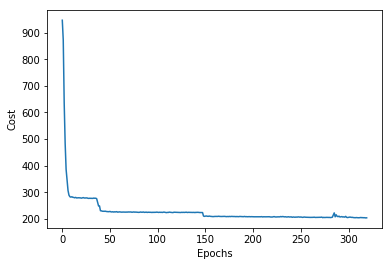

[54, 91, 127, 27, 77, 79, 114, 116, 0, 126, 130, 32, 112, 122, 114, 19, 7, 80, 121, 33, 66, 86, 122, 114, 60, 64, 96, 101, 92, 74, 50, 130, 96, 73, 128, 78, 7, 43, 72, 109, 24, 123, 88, 95, 34, 95, 118, 49]
['G', 'G', ' ', 'G', ' ', 'G', ' ', 'D', ' ', 'V', 'G', ' ', 'S', 'G', 'G', 'N']
Predicted: GG G G D VG SGGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
5.0
['G', 'G', 'G', 'G', ' ', 'A', 'W', ' ', 'G', ' ', 'G', 'G']
Predicted: GGGG AW G GG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
8.5
['G', 'G', 'G', 'G', 'K', 'R', 'Z', 'E', 'A', 'O', 'G', 'G', 'G']
Predicted: GGGGKRZEAOGGG
Ground truth: P L E A S A N T H I L L S
WER: 
24.0
['G', 'G', 'N', 'G', 'V', 'G', 'O', 'P', 'E', 'J', ' ', 'G', 'E', 'G', 'G']
Predicted: GGNGVGOPEJ GEGG
Ground truth: E R I C
WER: 
7.0
['G', 'G', 'G', 'G', 'F', 'D', 'O', 'E', ' ', 'G', 'G', 'G']
Predicted: GGGGFDOE GGG
Ground truth: ENTER NINE TWO EIGHT
WER: 
8.5
['G', 'E', 'G', 'E', 'G', 'G', ' ', 'Y', 'K', ' ', 'G', ' ', 'G', ' '

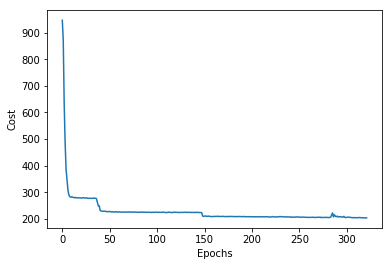

Number of epochs: 324
324
324
324


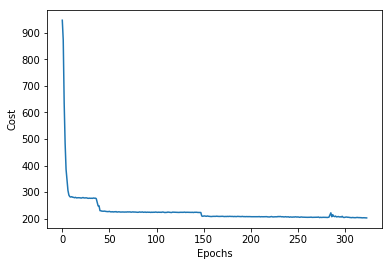

Number of epochs: 326
326
326
326


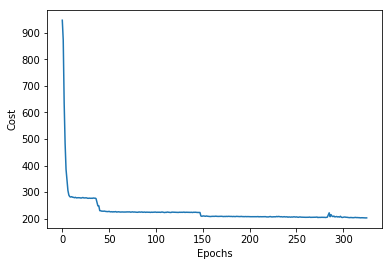

Number of epochs: 328
328
328
328


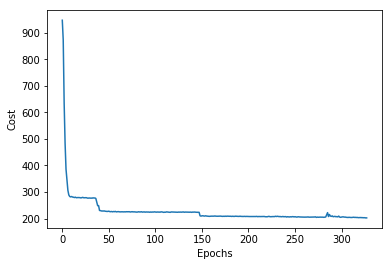

Number of epochs: 330
330
330
330


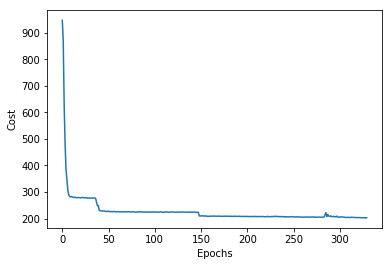

[17, 111, 17, 21, 24, 14, 17, 97, 68, 61, 103, 118, 109, 13, 3, 129, 23, 30, 103, 130, 52, 91, 128, 38, 54, 122, 35, 94, 8, 10, 44, 34, 56, 38, 93, 81, 85, 75, 53, 25, 42, 67, 85, 130, 17, 68, 56, 88]
['G', ' ', 'G', ' ', 'S', 'G', ' ', 'S', 'G', ' ', 'F', ' ', 'Y', 'S', 'G', ' ', ' ', 'S', 'G', ' ', 'G', 'N']
Predicted: G G SG SG F YSG  SG GN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
3.625
['G', 'G', 'G', 'G', ' ', 'A', 'C', ' ', 'G', ' ', 'G', 'G']
Predicted: GGGG AC G GG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
8.5
['G', 'G', 'G', 'G', 'K', 'R', 'Z', 'E', 'A', 'O', 'G', 'G', 'G']
Predicted: GGGGKRZEAOGGG
Ground truth: P L E A S A N T H I L L S
WER: 
24.0
['G', 'E', 'G', 'N', 'E', 'E', 'G', 'V', 'E', 'G', ' ', 'O', 'P', 'E', 'J', ' ', 'G', 'N', 'E', 'E', 'G', 'V', 'G', 'N']
Predicted: GEGNEEGVEG OPEJ GNEEGVGN
Ground truth: E R I C
WER: 
7.0
['G', 'G', 'G', 'G', ' ', 'F', 'D', 'O', 'E', ' ', 'G', 'G', 'G']
Predicted: GGGG FDOE GGG
Ground truth: ENTER NI

['G', 'G', 'N', 'G', ' ', 'G', ' ', 'J', 'T', ' ', 'G', ' ', ' ', 'G', 'G']
Predicted: GGNG G JT G  GG
Ground truth: ONE FIVE TWO TWO FOUR
WER: 
3.4
Number of epochs: 332
332
332
332


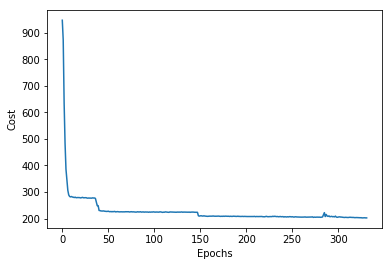

Number of epochs: 334
334
334
334


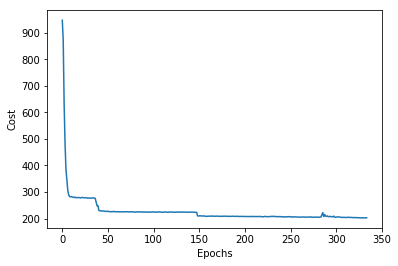

Number of epochs: 336
336
336
336


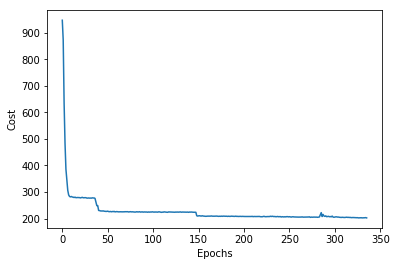

Number of epochs: 338
338
338
338


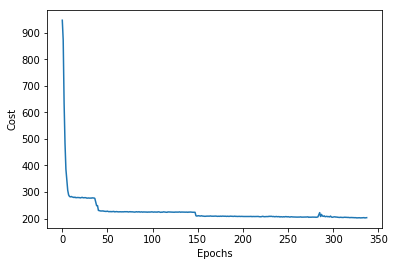

Number of epochs: 340
340
340
340


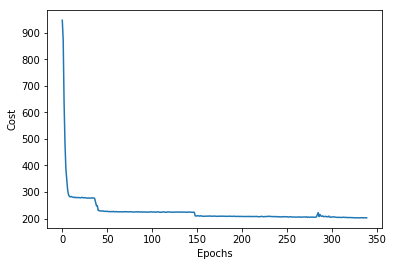

[22, 67, 34, 0, 83, 93, 56, 37, 7, 70, 24, 65, 39, 122, 8, 7, 124, 31, 130, 93, 71, 25, 5, 74, 11, 53, 76, 103, 42, 52, 41, 50, 81, 120, 38, 0, 57, 64, 124, 36, 122, 71, 111, 98, 24, 24, 117, 66]
['G', ' ', 'G', ' ', 'S', 'G', ' ', 'S', 'G', ' ', 'F', ' ', 'Y', 'S', 'G', ' ', ' ', 'S', 'G', ' ', 'G', 'N']
Predicted: G G SG SG F YSG  SG GN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
3.625
['G', 'G', 'G', 'G', ' ', 'A', 'C', ' ', 'G', ' ', 'G', 'G']
Predicted: GGGG AC G GG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
8.5
['G', 'G', 'G', 'G', 'K', 'R', 'Z', 'E', 'R', 'O', 'G', 'G', 'G']
Predicted: GGGGKRZEROGGG
Ground truth: P L E A S A N T H I L L S
WER: 
25.0
['G', 'E', 'G', 'N', 'E', 'E', 'G', 'V', 'E', 'G', 'O', 'P', 'E', 'J', ' ', 'G', 'N', 'E', 'E', 'E', 'G', 'V', 'G', 'N']
Predicted: GEGNEEGVEGOPEJ GNEEEGVGN
Ground truth: E R I C
WER: 
11.0
['G', 'G', 'G', 'G', 'F', 'D', 'O', 'E', ' ', 'G', 'G', 'G']
Predicted: GGGGFDOE GGG
Ground truth: ENTER NINE TWO EIG

Number of epochs: 342
342
342
342


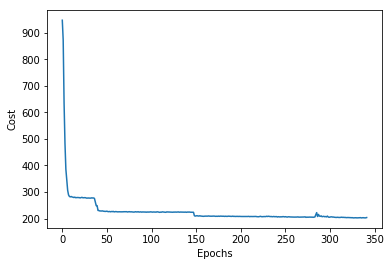

Number of epochs: 344
344
344
344


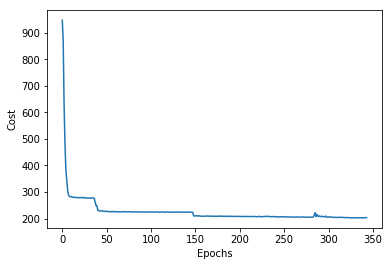

Number of epochs: 346
346
346
346


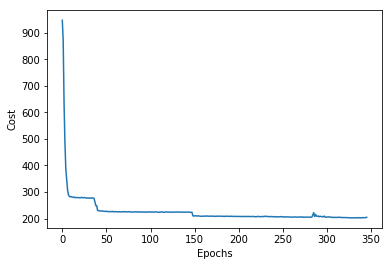

Number of epochs: 348
348
348
348


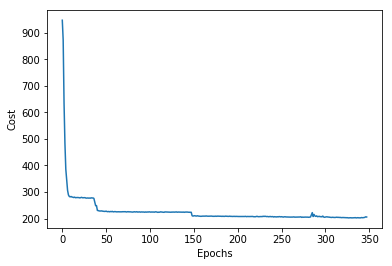

Number of epochs: 350
350
350
350


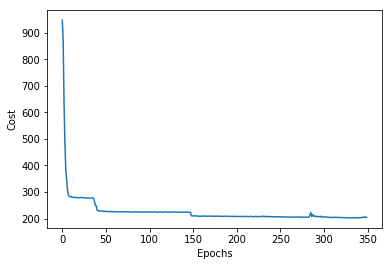

[2, 44, 21, 91, 65, 79, 96, 103, 121, 83, 80, 29, 63, 78, 37, 50, 38, 89, 97, 17, 8, 81, 108, 96, 94, 113, 96, 13, 113, 25, 98, 8, 85, 127, 41, 67, 67, 47, 98, 32, 65, 30, 81, 110, 71, 107, 74, 36]
['G', 'G', ' ', 'G', ' ', 'G', ' ', 'D', ' ', 'G', ' ', 'S', 'G', ' ', 'G', 'N']
Predicted: GG G G D G SG GN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
4.285714285714286
['G', 'G', 'G', 'G', ' ', 'A', 'W', ' ', 'G', ' ', 'G', ' ', 'G']
Predicted: GGGG AW G G G
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
6.6
['G', 'G', 'G', 'F', 'G', 'K', 'R', 'Z', 'F', 'R', 'O', 'G', 'F', 'G', 'G']
Predicted: GGGFGKRZFROGFGG
Ground truth: P L E A S A N T H I L L S
WER: 
25.0
['G', 'E', 'G', 'N', 'E', 'G', 'V', 'G', 'O', 'P', 'E', 'J', ' ', 'G', 'N', 'N', 'E', 'G', 'V', 'G', 'N']
Predicted: GEGNEGVGOPEJ GNNEGVGN
Ground truth: E R I C
WER: 
9.5
['G', 'G', 'G', 'G', ' ', 'F', 'D', 'O', 'E', ' ', 'O', ' ', 'G', 'G', 'G']
Predicted: GGGG FDOE O GGG
Ground truth: ENTER NINE TWO EIGHT
WE

Number of epochs: 352
352
352
352


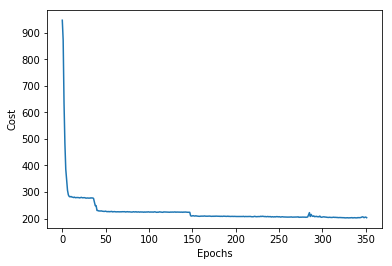

Number of epochs: 354
354
354
354


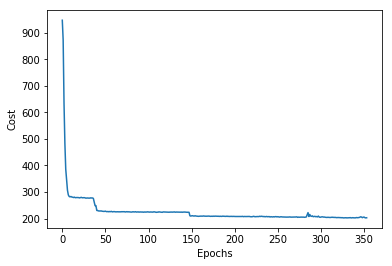

Number of epochs: 356
356
356
356


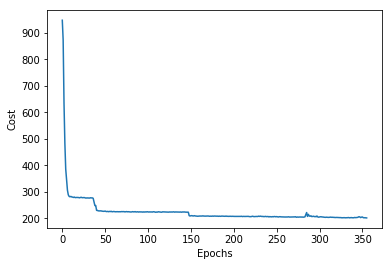

Number of epochs: 358
358
358
358


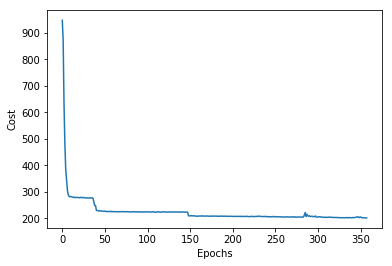

Number of epochs: 360
360
360
360


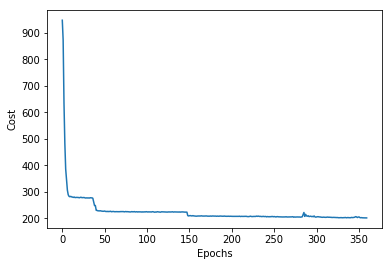

[19, 8, 37, 47, 83, 92, 78, 20, 126, 90, 52, 0, 117, 94, 92, 4, 86, 116, 57, 115, 105, 107, 123, 80, 16, 9, 31, 46, 114, 24, 88, 69, 40, 0, 28, 99, 81, 73, 120, 104, 123, 63, 40, 13, 124, 2, 111, 42]
['G', ' ', 'G', ' ', 'S', 'G', ' ', 'S', 'G', ' ', 'D', ' ', 'Y', 'S', 'G', ' ', ' ', 'S', 'G', ' ', 'G', 'N']
Predicted: G G SG SG D YSG  SG GN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
3.625
['G', 'G', 'G', 'G', ' ', 'A', 'W', ' ', 'G', ' ', 'G', 'G']
Predicted: GGGG AW G GG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
8.5
['G', 'G', 'G', 'R', 'Y', 'F', 'G', 'K', 'R', 'Z', 'F', 'A', 'O', 'G', 'F', 'G', 'G']
Predicted: GGGRYFGKRZFAOGFGG
Ground truth: P L E A S A N T H I L L S
WER: 
25.0
['G', 'E', 'G', 'N', 'E', 'E', 'G', 'V', 'E', 'G', ' ', 'O', 'P', 'E', 'J', 'Y', 'G', 'N', 'E', 'G', 'V', 'G', 'N']
Predicted: GEGNEEGVEG OPEJYGNEGVGN
Ground truth: E R I C
WER: 
10.5
['G', 'G', 'G', 'G', 'F', 'D', 'O', 'E', ' ', 'G', 'G', 'G']
Predicted: GGGGFDOE GGG
Ground tru

['G', 'G', 'N', 'G', ' ', 'G', ' ', 'K', 'T', ' ', 'G', 'N', ' ', 'G', 'G']
Predicted: GGNG G KT GN GG
Ground truth: ONE FIVE TWO TWO FOUR
WER: 
3.4
Number of epochs: 362
362
362
362


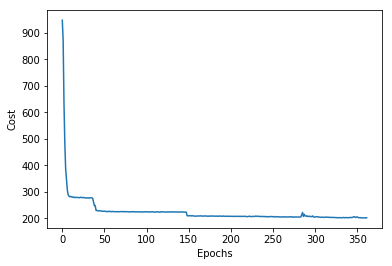

Number of epochs: 364
364
364
364


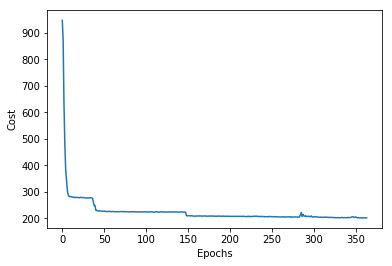

Number of epochs: 366
366
366
366


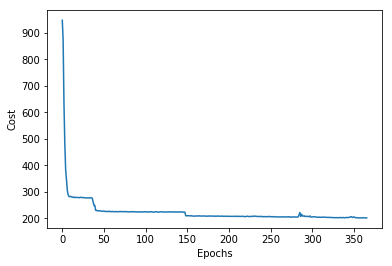

Number of epochs: 368
368
368
368


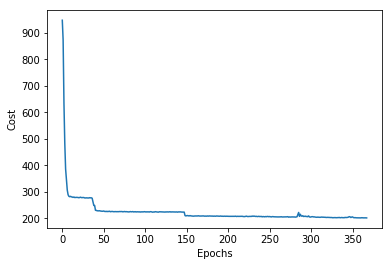

Number of epochs: 370
370
370
370


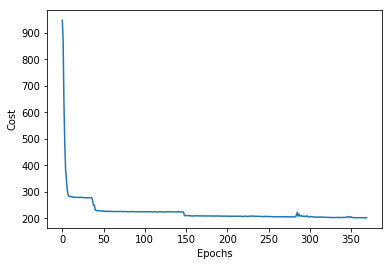

[76, 8, 86, 58, 123, 129, 31, 47, 24, 76, 53, 42, 18, 5, 43, 128, 121, 35, 47, 101, 10, 24, 105, 81, 13, 28, 87, 82, 31, 125, 27, 98, 120, 70, 63, 13, 94, 63, 5, 73, 60, 60, 90, 38, 70, 8, 97, 61]
['G', ' ', 'G', ' ', ' ', 'G', ' ', 'S', 'G', ' ', 'D', ' ', 'Y', 'S', 'G', ' ', ' ', 'S', 'G', ' ', 'G', 'N']
Predicted: G G  G SG D YSG  SG GN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
3.625
['G', 'G', 'G', 'G', ' ', 'A', 'W', ' ', 'G', ' ', 'G', 'G']
Predicted: GGGG AW G GG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
8.5
['G', 'G', 'G', 'R', 'Y', 'R', 'G', 'K', 'R', 'Z', 'F', 'R', 'O', 'G', 'F', 'G', 'G']
Predicted: GGGRYRGKRZFROGFGG
Ground truth: P L E A S A N T H I L L S
WER: 
25.0
['G', 'E', 'G', 'N', 'E', 'E', 'G', 'V', 'E', 'G', ' ', 'O', 'P', 'O', 'J', 'Y', 'G', 'N', 'E', 'E', 'G', 'V', 'G', 'N']
Predicted: GEGNEEGVEG OPOJYGNEEGVGN
Ground truth: E R I C
WER: 
11.0
['G', 'G', 'G', 'G', ' ', 'F', 'D', 'O', 'E', ' ', 'G', 'G', 'G']
Predicted: GGGG FDOE GGG
G

['G', 'G', 'G', 'G', 'C', 'P', ' ', 'V', ' ', 'G', 'G', 'G']
Predicted: GGGGCP V GGG
Ground truth: P I T T S B U R G H
WER: 
5.333333333333333
['G', 'G', ' ', 'G', ' ', 'G', ' ', 'K', 'Y', ' ', 'G', ' ', ' ', 'G', 'G']
Predicted: GG G G KY G  GG
Ground truth: ONE FIVE TWO TWO FOUR
WER: 
2.8333333333333335
Number of epochs: 372
372
372
372


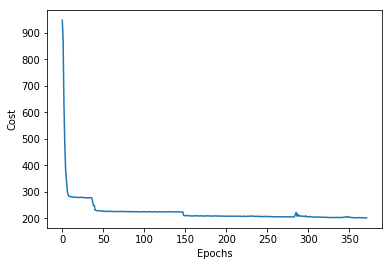

Number of epochs: 374
374
374
374


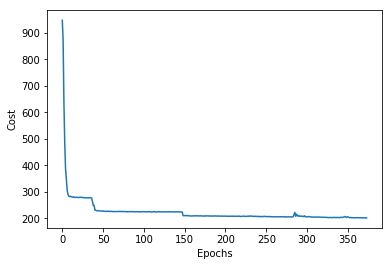

Number of epochs: 376
376
376
376


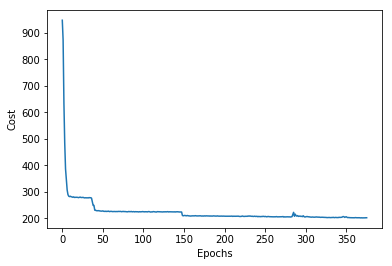

Number of epochs: 378
378
378
378


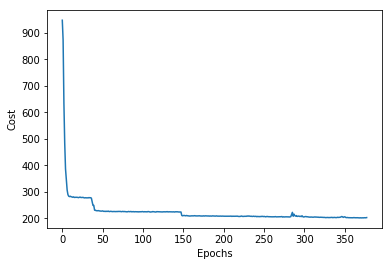

Number of epochs: 380
380
380
380


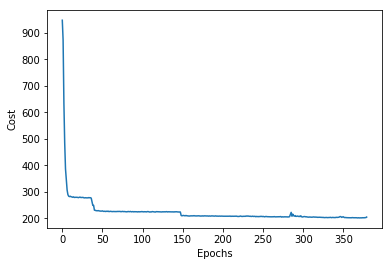

[2, 88, 48, 25, 57, 1, 16, 105, 115, 68, 42, 102, 50, 22, 84, 105, 65, 67, 5, 113, 59, 44, 90, 50, 111, 111, 108, 69, 75, 91, 6, 36, 99, 56, 122, 26, 121, 107, 42, 58, 58, 88, 56, 71, 106, 14, 57, 44]
['G', 'G', ' ', 'G', ' ', 'G', ' ', 'F', ' ', 'Y', 'G', ' ', 'S', 'G', ' ', 'G', 'N']
Predicted: GG G G F YG SG GN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
4.285714285714286
['G', 'G', 'G', 'G', ' ', 'A', 'W', ' ', 'G', ' ', 'G', 'G']
Predicted: GGGG AW G GG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
8.5
['G', 'G', 'G', 'Y', 'R', 'G', 'K', 'R', 'Z', 'F', 'R', 'O', 'G', 'F', 'G', 'G']
Predicted: GGGYRGKRZFROGFGG
Ground truth: P L E A S A N T H I L L S
WER: 
25.0
['G', 'E', 'G', 'N', 'E', 'E', 'G', 'V', 'G', ' ', 'P', 'E', 'J', ' ', 'G', 'N', 'E', 'E', 'G', 'V', 'G', 'N']
Predicted: GEGNEEGVG PEJ GNEEGVGN
Ground truth: E R I C
WER: 
6.333333333333333
['G', 'G', 'G', 'G', 'F', 'D', 'O', 'E', ' ', 'G', 'G', 'G']
Predicted: GGGGFDOE GGG
Ground truth: ENTER NINE T

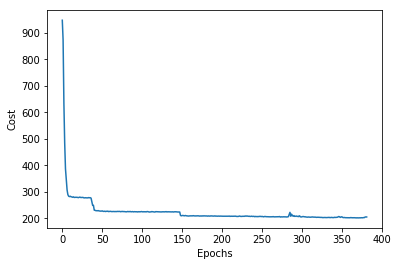

Number of epochs: 384
384
384
384


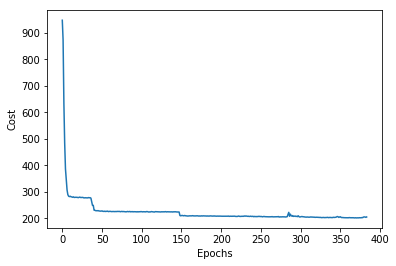

Number of epochs: 386
386
386
386


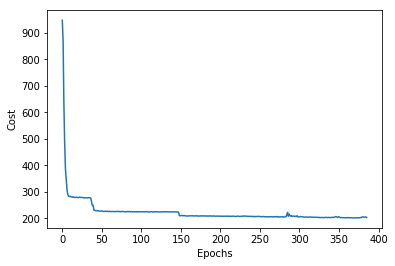

Number of epochs: 388
388
388
388


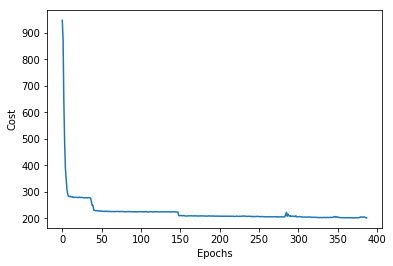

Number of epochs: 390
390
390
390


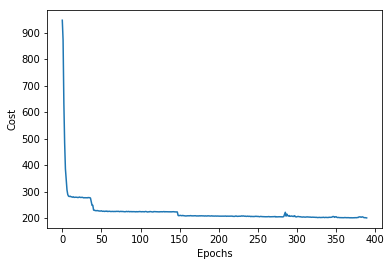

[98, 63, 84, 38, 77, 59, 8, 96, 14, 46, 39, 69, 37, 76, 94, 87, 124, 79, 40, 9, 113, 44, 82, 17, 125, 70, 88, 53, 76, 63, 119, 84, 25, 112, 93, 120, 13, 7, 7, 97, 113, 1, 15, 16, 84, 115, 16, 114]
['G', ' ', 'G', ' ', 'S', 'G', ' ', 'S', 'G', ' ', 'D', ' ', 'Y', 'S', 'G', ' ', ' ', 'S', 'G', ' ', 'G', 'N']
Predicted: G G SG SG D YSG  SG GN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
3.625
['G', 'G', 'G', 'G', ' ', 'A', 'W', ' ', 'G', ' ', 'G', 'G']
Predicted: GGGG AW G GG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
8.5
['G', 'G', 'G', 'R', 'Y', 'F', 'G', 'K', 'R', 'Z', 'F', 'R', 'O', 'G', 'F', 'G', 'G']
Predicted: GGGRYFGKRZFROGFGG
Ground truth: P L E A S A N T H I L L S
WER: 
25.0
['G', 'E', 'G', 'N', 'E', 'E', 'G', 'V', 'E', 'G', ' ', 'O', 'P', 'E', 'D', 'Y', 'G', 'N', 'E', 'E', 'G', 'V', 'E', 'G', 'N']
Predicted: GEGNEEGVEG OPEDYGNEEGVEGN
Ground truth: E R I C
WER: 
11.5
['G', 'G', 'G', 'G', ' ', 'F', 'D', 'O', 'E', ' ', 'G', 'G', 'G']
Predicted: GGGG FDOE

['G', 'G', 'G', 'G', 'C', 'P', ' ', 'Q', ' ', 'G', 'G', 'G']
Predicted: GGGGCP Q GGG
Ground truth: P I T T S B U R G H
WER: 
5.333333333333333
['G', 'G', 'N', 'G', ' ', 'G', ' ', 'J', 'T', ' ', 'G', 'N', ' ', 'G', 'G']
Predicted: GGNG G JT GN GG
Ground truth: ONE FIVE TWO TWO FOUR
WER: 
3.4
Number of epochs: 392
392
392
392


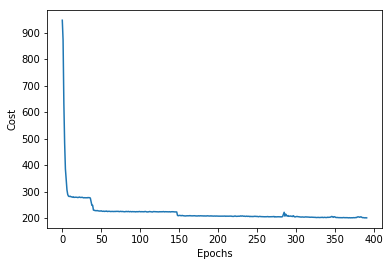

Number of epochs: 394
394
394
394


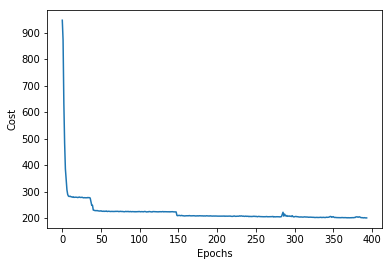

Number of epochs: 396
396
396
396


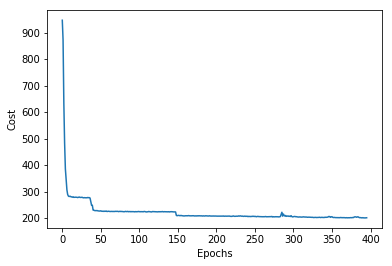

Number of epochs: 398
398
398
398


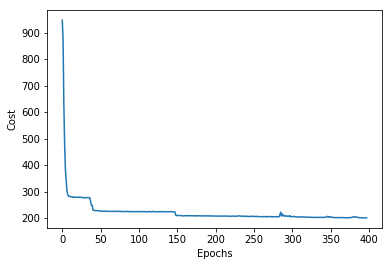

Number of epochs: 400
400
400
400


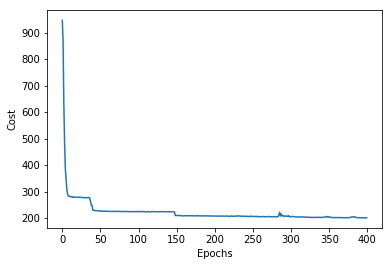

[103, 27, 89, 70, 108, 8, 32, 2, 23, 36, 55, 38, 60, 62, 42, 86, 115, 108, 103, 7, 123, 63, 104, 115, 121, 58, 97, 101, 99, 114, 1, 27, 29, 103, 93, 64, 13, 111, 77, 120, 77, 61, 29, 14, 94, 13, 18, 110]
['G', ' ', 'G', ' ', 'G', ' ', 'S', 'G', ' ', 'D', ' ', 'Y', 'S', 'G', ' ', ' ', 'S', 'G', ' ', 'G', 'N']
Predicted: G G G SG D YSG  SG GN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
3.625
['G', 'G', 'G', 'G', ' ', 'A', 'W', ' ', 'G', ' ', 'G', 'G']
Predicted: GGGG AW G GG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
8.5
['G', 'G', 'G', 'Y', 'F', 'G', 'K', 'R', 'Z', 'F', 'R', 'O', 'G', 'F', 'G', 'G']
Predicted: GGGYFGKRZFROGFGG
Ground truth: P L E A S A N T H I L L S
WER: 
25.0
['G', 'E', 'G', 'N', 'E', 'E', 'G', 'V', 'G', 'O', 'F', 'E', 'J', 'Y', 'G', 'N', 'E', 'E', 'G', 'V', 'G', 'N']
Predicted: GEGNEEGVGOFEJYGNEEGVGN
Ground truth: E R I C
WER: 
21.0
['G', 'G', 'G', 'G', 'F', 'D', 'O', 'E', ' ', 'G', 'G', 'G']
Predicted: GGGGFDOE GGG
Ground truth: ENTER NINE

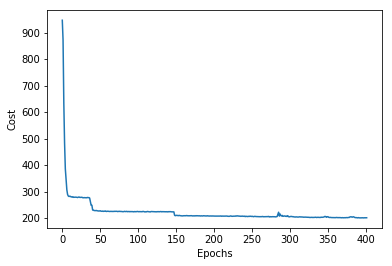

Number of epochs: 404
404
404
404


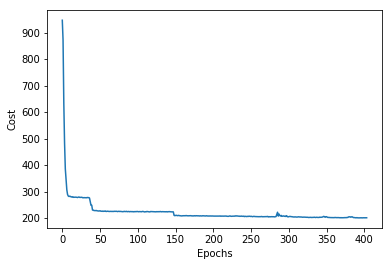

Number of epochs: 406
406
406
406


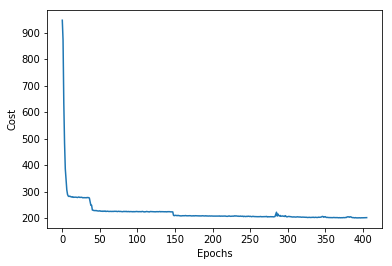

Number of epochs: 408
408
408
408


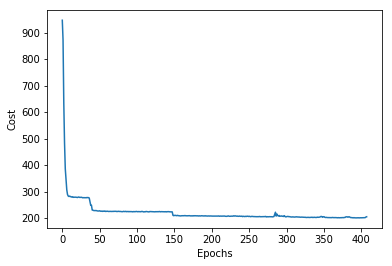

Number of epochs: 410
410
410
410


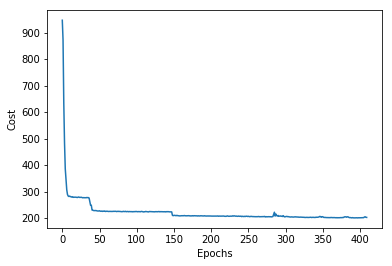

[95, 50, 84, 72, 66, 79, 119, 36, 102, 10, 16, 78, 118, 25, 51, 70, 29, 61, 22, 105, 109, 47, 83, 66, 45, 96, 76, 76, 97, 54, 120, 113, 34, 69, 31, 49, 4, 103, 59, 21, 84, 92, 19, 20, 66, 112, 43, 49]
['G', ' ', 'G', ' ', 'G', ' ', ' ', 'G', ' ', 'D', ' ', 'O', 'G', ' ', ' ', 'S', 'G', ' ', 'S', 'G', 'N']
Predicted: G G G  G D OG  SG SGN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
3.625
['G', 'G', 'G', 'G', ' ', 'A', 'W', ' ', 'G', ' ', 'G', ' ', 'G']
Predicted: GGGG AW G G G
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
6.6
['G', 'G', 'F', ' ', 'G', 'R', 'F', 'Y', 'F', 'G', 'K', 'R', 'Z', 'F', 'R', 'O', 'G', ' ', 'F', 'G', 'F', 'F', 'G']
Predicted: GGF GRFYFGKRZFROG FGFFG
Ground truth: P L E A S A N T H I L L S
WER: 
7.666666666666667
['G', 'E', 'G', 'N', 'E', 'E', 'G', 'V', 'E', 'E', 'G', ' ', 'P', 'E', 'B', 'S', 'G', 'N', 'N', 'E', 'G', 'V', 'E', 'E', 'E', 'G', 'N']
Predicted: GEGNEEGVEEG PEBSGNNEGVEEEGN
Ground truth: E R I C
WER: 
12.5
['G', 'G', 'G', 'G', 

['G', ' ', 'G', ' ', ' ', ' ', 'G', ' ', 'G', ' ', 'J', 'H', 'T', ' ', 'G', ' ', ' ', 'S', 'G', ' ', ' ', 'G', 'H']
Predicted: G G   G G JHT G  SG  GH
Ground truth: R H N G A FIFTY FOUR EIGHTY THREE
WER: 
2.625
['G', 'E', 'G', 'E', 'G', 'E', 'G', 'A', 'E', 'G', 'N', ' ', 'E', 'G', 'V', 'E', 'G']
Predicted: GEGEGEGAEGN EGVEG
Ground truth: MAY SECOND NINETEEN SIXTY FIVE
WER: 
12.5
['G', 'E', 'E', 'G', 'E', 'G', 'E', 'G', ' ', 'Q', ' ', 'E', ' ', 'G', 'N', ' ', 'E', 'G', 'T', 'E', 'E', 'G', 'N']
Predicted: GEEGEGEG Q E GN EGTEEGN
Ground truth: ONE FIVE TWO THREE SIX
WER: 
3.8
['G', 'G', ' ', 'G', 'G', ' ', 'C', 'P', ' ', 'N', ' ', 'J', 'G', ' ', ' ', 'G', 'G']
Predicted: GG GG CP N JG  GG
Ground truth: P I T T S B U R G H
WER: 
2.3333333333333335
['G', 'G', 'N', ' ', 'G', ' ', 'G', ' ', 'J', 'Y', ' ', 'G', 'N', ' ', ' ', 'G', 'T', 'A', 'G']
Predicted: GGN G G JY GN  GTAG
Ground truth: ONE FIVE TWO TWO FOUR
WER: 
2.8333333333333335
Number of epochs: 412
412
412
412


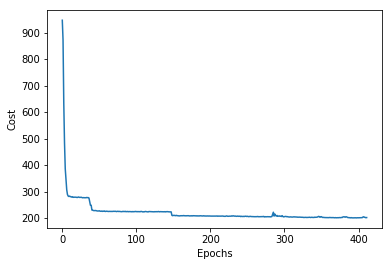

Number of epochs: 414
414
414
414


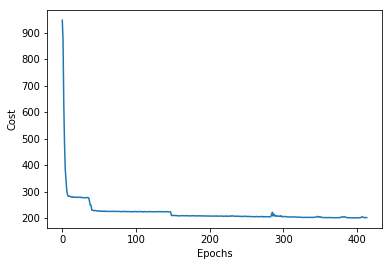

Number of epochs: 416
416
416
416


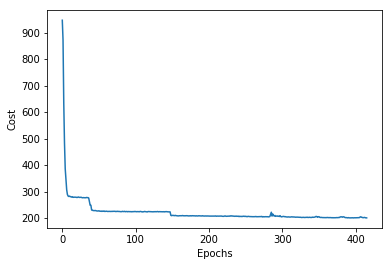

Number of epochs: 418
418
418
418


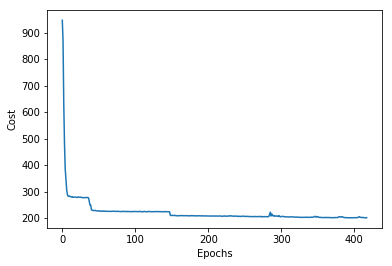

Number of epochs: 420
420
420
420


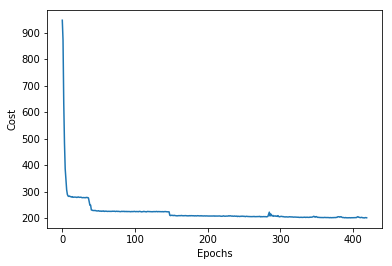

[98, 5, 110, 115, 50, 98, 75, 67, 105, 85, 90, 114, 8, 50, 101, 110, 91, 109, 50, 104, 70, 11, 55, 48, 19, 59, 34, 20, 6, 88, 115, 12, 24, 57, 21, 109, 28, 103, 24, 63, 94, 52, 16, 126, 23, 71, 36, 74]
['G', ' ', 'G', ' ', 'G', ' ', ' ', 'G', ' ', 'D', ' ', 'S', 'G', ' ', ' ', 'S', 'G', ' ', 'G', 'H']
Predicted: G G G  G D SG  SG GH
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
3.75
['G', 'G', 'G', 'G', ' ', 'A', 'W', ' ', 'G', ' ', 'G', ' ', 'G']
Predicted: GGGG AW G G G
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
6.6
['G', 'G', 'F', ' ', 'G', 'R', 'F', 'Y', 'F', 'G', 'K', 'R', 'Z', 'F', 'R', 'O', 'G', ' ', 'F', 'G', 'F', 'F', 'G']
Predicted: GGF GRFYFGKRZFROG FGFFG
Ground truth: P L E A S A N T H I L L S
WER: 
7.666666666666667
['G', 'E', 'E', 'G', 'N', 'E', 'E', 'G', 'T', 'E', 'E', 'G', ' ', 'C', 'E', 'B', 'Y', 'G', 'N', 'E', 'E', 'E', 'G', 'V', 'E', 'E', 'E', 'G', 'N']
Predicted: GEEGNEEGTEEG CEBYGNEEEGVEEEGN
Ground truth: E R I C
WER: 
13.0
['G', 'G', 'G',

['G', 'E', 'G', 'E', 'G', 'E', 'G', 'B', 'E', 'G', 'N', ' ', 'E', 'G', 'V', 'E', 'G']
Predicted: GEGEGEGBEGN EGVEG
Ground truth: MAY SECOND NINETEEN SIXTY FIVE
WER: 
12.5
['G', 'E', 'O', 'G', 'E', 'G', 'E', 'G', 'Q', ' ', 'E', ' ', 'G', 'E', 'G', 'T', 'E', 'G', 'N']
Predicted: GEOGEGEGQ E GEGTEGN
Ground truth: ONE FIVE TWO THREE SIX
WER: 
6.0
['G', 'G', ' ', 'G', 'G', 'C', 'P', ' ', 'Q', ' ', 'J', 'G', ' ', 'G', 'G']
Predicted: GG GGCP Q JG GG
Ground truth: P I T T S B U R G H
WER: 
2.8
['G', 'G', 'N', 'G', ' ', 'G', ' ', 'J', 'Y', ' ', 'G', 'N', ' ', 'G', 'G']
Predicted: GGNG G JY GN GG
Ground truth: ONE FIVE TWO TWO FOUR
WER: 
3.4
Number of epochs: 422
422
422
422


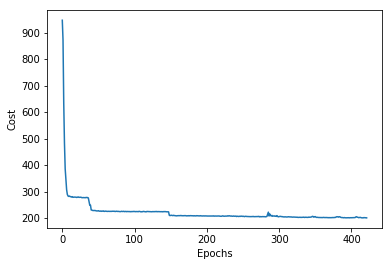

Number of epochs: 424
424
424
424


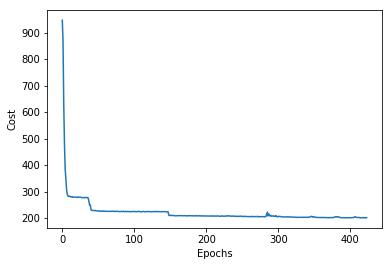

Number of epochs: 426
426
426
426


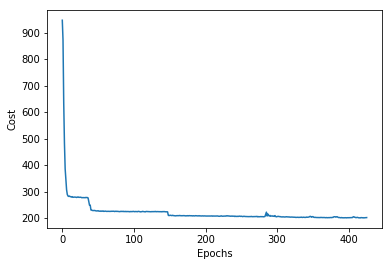

Number of epochs: 428
428
428
428


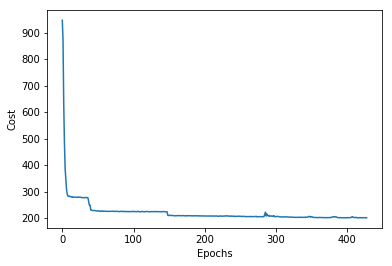

Number of epochs: 430
430
430
430


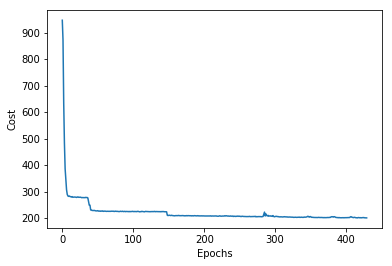

[52, 63, 121, 65, 46, 46, 16, 48, 54, 70, 30, 9, 57, 52, 124, 60, 108, 89, 68, 67, 44, 121, 98, 109, 37, 93, 18, 101, 102, 57, 81, 18, 30, 29, 120, 66, 63, 35, 126, 99, 7, 36, 28, 4, 40, 100, 103, 46]
['G', 'S', 'G', ' ', 'S', 'G', ' ', 'S', 'G', ' ', 'D', ' ', 'S', 'G', ' ', ' ', 'S', 'G', ' ', 'G', 'N']
Predicted: GSG SG SG D SG  SG GN
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
4.0
['G', 'G', 'G', 'G', ' ', 'A', 'W', ' ', 'G', ' ', 'G', 'G']
Predicted: GGGG AW G GG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
8.5
['G', 'G', 'F', 'G', 'R', 'Y', 'F', 'G', 'K', 'R', 'Z', 'F', 'R', 'O', 'G', 'F', 'G', 'F', 'F', 'G']
Predicted: GGFGRYFGKRZFROGFGFFG
Ground truth: P L E A S A N T H I L L S
WER: 
25.0
['G', 'E', 'E', 'G', 'N', 'E', 'E', 'G', 'T', 'E', 'G', ' ', 'O', 'S', 'E', 'B', 'Y', 'G', 'N', 'E', 'E', 'G', 'V', 'G', 'N']
Predicted: GEEGNEEGTEG OSEBYGNEEGVGN
Ground truth: E R I C
WER: 
11.5
['G', 'G', 'G', 'G', ' ', 'O', 'D', ' ', 'E', ' ', 'G', 'G', 'G']
Predic

Number of epochs: 432
432
432
432


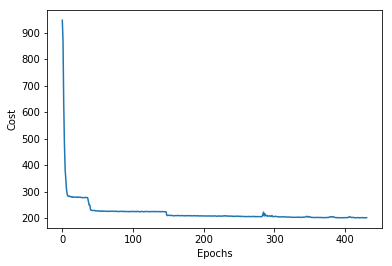

Number of epochs: 434
434
434
434


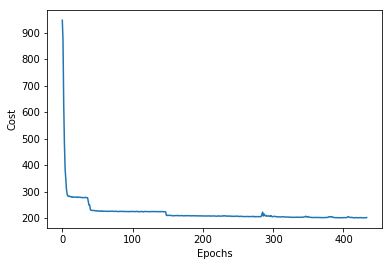

Number of epochs: 436
436
436
436


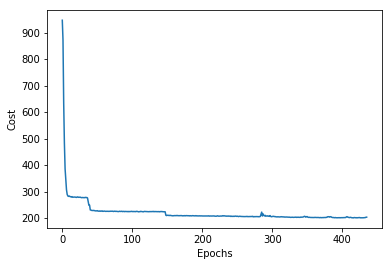

Number of epochs: 438
438
438
438


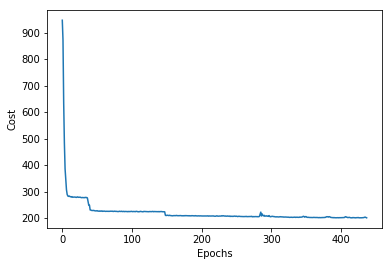

Number of epochs: 440
440
440
440


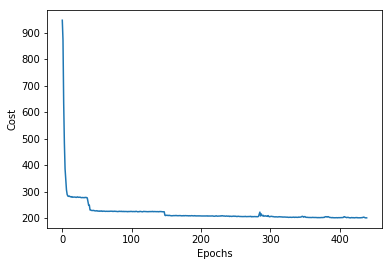

[107, 11, 55, 95, 13, 8, 44, 63, 20, 19, 124, 80, 42, 99, 1, 113, 11, 65, 62, 88, 33, 13, 84, 128, 108, 100, 1, 69, 50, 36, 23, 102, 42, 111, 55, 72, 119, 88, 3, 79, 55, 37, 20, 118, 79, 129, 75, 119]
['G', ' ', 'G', ' ', 'G', ' ', 'G', ' ', 'D', ' ', 'S', 'G', ' ', ' ', ' ', 'S', 'G', ' ', 'G', 'H']
Predicted: G G G G D SG   SG GH
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
3.75
['G', 'G', 'G', 'G', ' ', 'A', 'W', ' ', 'G', ' ', 'G', 'G']
Predicted: GGGG AW G GG
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
8.5
['G', 'G', 'F', ' ', 'G', 'R', ' ', 'R', 'G', 'K', 'R', 'Z', 'F', 'R', 'O', 'G', ' ', 'F', 'G', 'F', 'F', 'G']
Predicted: GGF GR RGKRZFROG FGFFG
Ground truth: P L E A S A N T H I L L S
WER: 
5.5
['G', 'E', 'E', 'G', 'N', 'E', 'E', 'G', 'T', 'E', 'G', ' ', 'C', 'E', 'B', 'Y', 'G', 'N', 'E', 'G', 'V', 'G', 'N']
Predicted: GEEGNEEGTEG CEBYGNEGVGN
Ground truth: E R I C
WER: 
10.0
['G', 'G', 'G', 'G', ' ', 'O', 'D', ' ', 'E', ' ', 'G', 'G', 'G']
Predicted: G

Number of epochs: 442
442
442
442


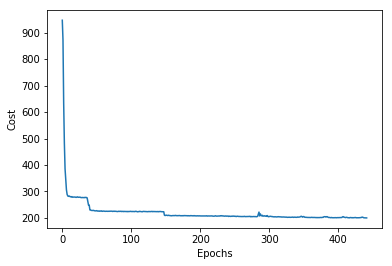

Number of epochs: 444
444
444
444


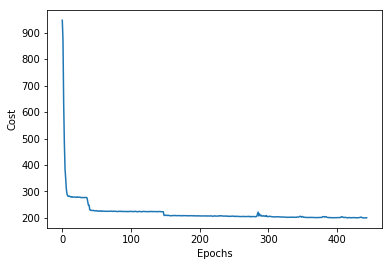

Number of epochs: 446
446
446
446


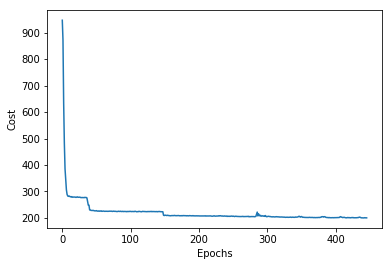

Number of epochs: 448
448
448
448


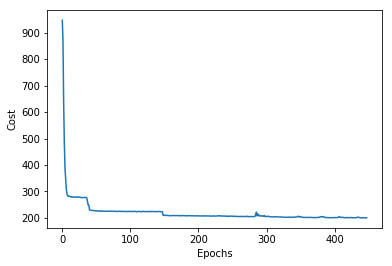

Number of epochs: 450
450
450
450


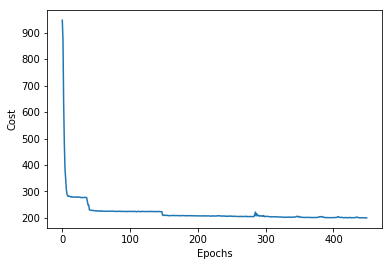

[85, 105, 0, 120, 59, 21, 119, 26, 100, 71, 128, 7, 65, 54, 66, 26, 53, 106, 38, 109, 38, 46, 85, 116, 19, 39, 93, 8, 127, 111, 72, 70, 59, 76, 107, 33, 116, 125, 67, 14, 4, 37, 112, 111, 128, 84, 94, 72]
['U', ' ', 'U', ' ', 'U', ' ', 'U', ' ', 'D', ' ', 'A', 'S', 'U', ' ', 'S', 'U', ' ', 'U', 'H']
Predicted: U U U U D ASU SU UH
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
3.75
['U', 'U', 'U', 'U', ' ', 'A', 'W', ' ', 'U', ' ', 'U', 'U']
Predicted: UUUU AW U UU
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
8.25
['U', 'U', 'U', 'R', ' ', 'R', 'U', 'K', 'R', 'Z', 'F', 'R', 'O', 'U', 'R', 'F', 'U', 'F', 'U']
Predicted: UUUR RUKRZFROURFUFU
Ground truth: P L E A S A N T H I L L S
WER: 
12.0
['U', 'E', 'U', 'N', 'E', 'E', 'U', 'T', 'E', 'U', 'R', 'C', 'E', 'B', 'Y', 'U', 'N', 'E', 'E', 'U', 'V', 'U', 'N']
Predicted: UEUNEEUTEURCEBYUNEEUVUN
Ground truth: E R I C
WER: 
21.0
['U', 'U', 'U', 'U', 'O', 'D', ' ', 'E', ' ', 'U', 'U', 'U']
Predicted: UUUUOD E UUU
Ground trut

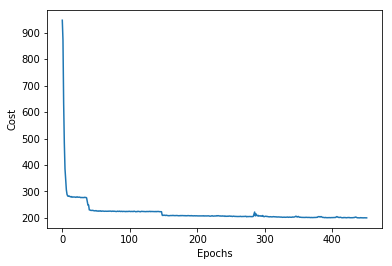

Number of epochs: 454
454
454
454


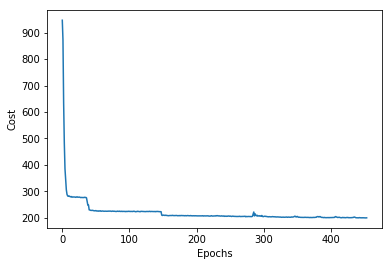

Number of epochs: 456
456
456
456


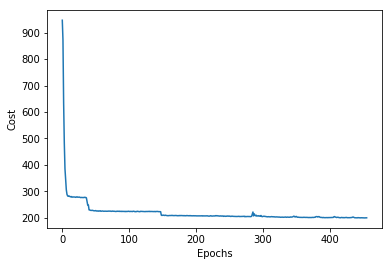

Number of epochs: 458
458
458
458


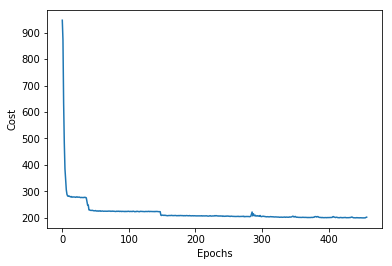

Number of epochs: 460
460
460
460


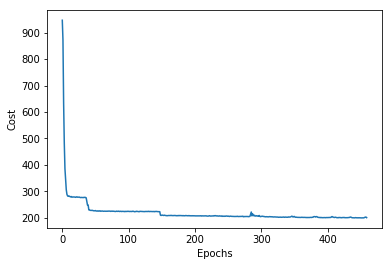

[53, 127, 36, 62, 99, 70, 17, 88, 33, 42, 104, 0, 116, 53, 38, 1, 101, 47, 10, 66, 36, 56, 16, 88, 30, 17, 27, 11, 35, 49, 117, 8, 106, 89, 6, 109, 113, 9, 9, 70, 44, 9, 11, 20, 73, 64, 118, 99]
['I', 'I', ' ', 'I', ' ', 'I', ' ', 'D', ' ', 'A', 'I', ' ', 'S', 'I', ' ', 'I', 'K']
Predicted: II I I D AI SI IK
Ground truth: JANUARY SEVENTH NINETEEN SIXTY SEVEN
WER: 
4.142857142857143
['I', 'I', 'I', 'I', ' ', 'N', 'Q', ' ', 'I', ' ', 'I', 'I']
Predicted: IIII NQ I II
Ground truth: W Y A T U SEVENTY SEVEN SEVENTY SEVEN
WER: 
8.25
['I', 'I', 'I', ' ', 'R', 'I', 'K', 'R', 'Z', 'F', 'R', 'O', 'I', 'R', 'I', 'I']
Predicted: III RIKRZFROIRII
Ground truth: P L E A S A N T H I L L S
WER: 
11.5
['I', 'E', 'I', 'N', 'E', 'E', 'I', 'V', 'I', 'R', 'C', 'E', 'B', 'Y', 'I', 'N', 'E', 'E', 'I', 'V', 'I', 'N']
Predicted: IEINEEIVIRCEBYINEEIVIN
Ground truth: E R I C
WER: 
19.0
['I', 'I', 'I', 'I', 'O', 'D', ' ', 'E', ' ', 'I', 'I', 'I']
Predicted: IIIIOD E III
Ground truth: ENTER NINE TWO EIGHT
WER: 
5.3

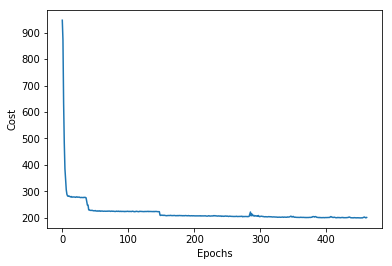

Number of epochs: 464
464
464
464


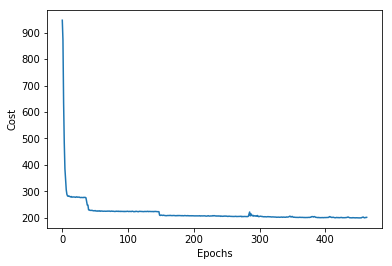

Number of epochs: 466
466
466
466


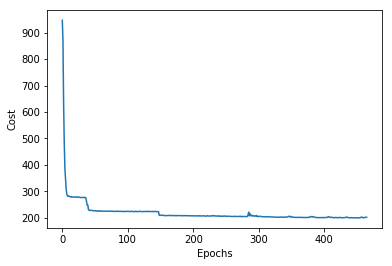

KeyboardInterrupt: 

In [52]:
counter = 0

torch.set_default_tensor_type('torch.FloatTensor')

costs=[]
costs_eval=[]
num_evals=0
epoch=0
while epoch < num_epochs:
    for i in range(int(num_samples/batch_size)):
        net.train()

        sample = numpy.empty([batch_size,1, 641, 40])
        
        ground_truth_sizes = torch.empty(batch_size)
        probs_sizes = torch.empty(batch_size)
        
        ground_truth_string_int = []
        avg_cost=0
        for j in range(batch_size):
            samp = numpy.asarray(Ms[i * batch_size + j][0], dtype=numpy.float32).T
            sample[j][0] = samp
            
            string = ''.join(labels[i * batch_size + j])

            ground_truth_sizes[j] = len(string)
            probs_sizes[j] = 319

            for character in string:
                if(character == " "):
                    number = 27
                else:
                    number = ord(character) - 64
                ground_truth_string_int.append(number)
        #print(sample.shape)
        
        input_sample=torch.from_numpy(sample)
        
        
        #print(input_sample.shape)
        #print("Len of truth: " + str(len(ground_truth_string_int)))
        #print("sum of truths: " + str(sum(ground_truth_sizes)))

        ground_truth = torch.IntTensor(ground_truth_string_int)
        #print("going into network.")
        #print(input_sample)
        out = net(Variable(input_sample).float())

        
        #greedy_decoder(out[0], all_labels)
        
        #print("out:")
        #print(out.shape)
        
        #print("probs sizes: " + str(probs_sizes))

        #run the criterion
        optimizer.zero_grad()

        #print(ground_truth.shape)
        #input must be in shape seq_length x batch size x outputs -> 641 x 1 x 28/27 (depends if we use spaces or not)
        cost=criterion(out.transpose(0,1), torch.tensor(ground_truth_string_int).int(), probs_sizes.int(), ground_truth_sizes.int())
        cost.backward()
        optimizer.step()
        #print(cost)
        avg_cost = avg_cost+cost.item()/batch_size
        
    #print(avg_cost)
    avg_cost=avg_cost
    epoch = epoch + 1
    costs.append(avg_cost)
    
    #plots the average cost
    if(epoch%2 == 0 and epoch > 0):
        print("Number of epochs: "  + str(epoch))
        display_cost(costs, epoch)
    
    error_rates=[]

    #evaluation not really implemented yet.    
    if(epoch%valid_epochs == 0 and epoch > 0):
        net.eval()
        with torch.no_grad():
            indices = [0]*batch_size
            
            for j in range(batch_size):
                indices[j] = random.randint(0, len(Ms_valid) - 1)
            print(indices)
            
            avg_error_rate = 0
            for j in range(batch_size):
                sample = numpy.empty([batch_size,1, 641, 40])
                sample[0][0] = Ms_valid[j][0].T



                out = net(Variable(torch.from_numpy(sample).float()))
                
                ground_truth = ''.join(labels_valid[j])
                predicted = ''.join(greedy_decoder(out[0], all_labels))
                print("Predicted: " + predicted)
                print("Ground truth: " + ground_truth)
                wer = WER(predicted, ground_truth)
                print("WER: ")
                print(wer)
                avg_error_rate = avg_error_rate + wer

            avg_error_rate/batch_size
            error_rates.append(avg_error_rate)
        

In [ ]:
i = 0

costs=[]
while i < num_epochs:
    j=0
    
    net.train()
    avg_cost = 0
    while j < num_samples:
        #here we select a sample Ms is in format [number of samples][1][sequence_length][num_features]
        sample = numpy.empty([1,1, 641, 40])
        sample[0][0] = Ms[j][0].T
        sample_1 = sample[0].reshape((641,1, 40))
        
        #output from the NN
        out = net(Variable(torch.from_numpy(sample).float()))
        maximal, indices = out[0].max(1)
        
            
        
        #changes string to numbers - classes are 28 and class 0 - 25 should be A-Z, 26 is space and 27 blank
        string = ''.join(labels[j])
        ground_truth_string_int = []
        for character in string:
            if(character == " "):
                number = 27
            else:
                number = ord(character) - 64
            ground_truth_string_int.append(number)
        
        if(j%20 == 0 and i%5 == 0):
            greedy_decoder(out[0], all_labels)
            print(ground_truth_string_int)
        #construct ground truth tensor
        ground_truth = torch.IntTensor(ground_truth_string_int)

        
        #length of the ground truth sample
        ground_truth_sizes = torch.IntTensor([len(ground_truth)])
        
        
        #length of sequence - 641 in our case
        probs_sizes = torch.IntTensor([out.shape[1]])
        
        
        #run the criterion
        optimizer.zero_grad()
        
        
        
        #input must be in shape seq_length x batch size x outputs -> 641 x 1 x 28/27 (depends if we use spaces or not)
        cost=criterion(out.transpose(0,1).contiguous(), ground_truth, probs_sizes, ground_truth_sizes)
        cost.backward()
        optimizer.step()
        
        
        #we try to display our current cost
        if (i%1==0):
            print("Cost: ")
            print(cost.item())
            beam_decoder = CTCBeamDecoder(all_labels, blank_id=27)
            beam_res, beam_scores, timesteps, sequence_lens = beam_decoder.decode(probs=out, seq_lens=ground_truth_sizes)
            for j, beam in enumerate(beam_res[0]):
                output_string = ''.join([all_labels[x] for x in beam[0:sequence_lens[0][j]]])
                #print(output_string) #uncomment this line to display the 'result'
        j = j + 1
        avg_cost = avg_cost + cost.item()
        print(avg_cost)
    avg_cost = avg_cost / num_samples
    costs.append(avg_cost)
    
    
    #plots the average cost
    if(i%2 == 0 and i > 0):
        display_cost(costs, i)
        
    net.eval()
    #evaluation not really implemented yet.    
    if(i%valid_epochs == 0):
        net.eval()
        with torch.no_grad():
            sample = numpy.empty([1,1, 641, 40])
            sample[0][0] = Ms[0][0].T
            sample_1 = sample[0].reshape(641, 1, 40)



            out = net(Variable(torch.from_numpy(sample_1).float()))
            
            string = ''.join(labels[0])
            output = []
            for character in string:
                if(character == " "):
                    number = 26
                else:
                    number = ord(character) - 65
                output.append(number)

            labels_crit = torch.IntTensor(output)

            label_sizes = torch.IntTensor([len(labels_crit)])
            beam_decoder = CTCBeamDecoder(all_labels, blank_id=27)
            beam_res, beam_scores, timesteps, sequence_lens = beam_decoder.decode(probs=out, seq_lens=label_sizes)


            for j, beam in enumerate(beam_res[0]):
                output_string = ''.join([all_labels[x] for x in beam[0:sequence_lens[0][j]]])
                #print(output_string)
            #print(output_string)
            print(labels[0])
    i = i + 1

# References

Up until this point we used various different libraries.

* For CTC cost we are using a warp-ctc function created by BAIDU which was recommended here: https://distill.pub/2017/ctc/
* It was also used in DeepSpeech: https://github.com/SeanNaren/deepspeech.pytorch - we use different architecture and many things are different, since warp-ctc does not contain much documentation, we had to check out the implementation. In the end this one was only useful to search for the libraries.

* Libraries we used:

  * warp-ctc pytorch binding - to know how to use this one, we had to play with the unit tests, since the library hardly contains any documentation.
  
  https://github.com/SeanNaren/warp-ctc
  
  * ctcdecode - for beamsearch to construct the string in the evaluation. We still have problem to understand how to build it properly though.
  
  https://github.com/githubharald/CTCDecoder
  
  * Both of the libraries lack much documentation are difficult to understand

In [67]:
print(type(Ms[0][0]))

<type 'numpy.ndarray'>
